In [1]:
%matplotlib inline
import pandas as pd
from glob import glob
import json
import numpy as np
import os

from sklearn import metrics

pd.set_option('display.max_rows', 500)


import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_context('paper')
sns.set_style('whitegrid')
sns.set_palette('colorblind')

# AAFC Salmonella AMR Analysis

Analyses of the 100 Salmonella Genomes from Moussa and Attiq:

- Serovar Prediction
    - Genomic Prediction
    - Molecular Prediction
    - Comparsion
- AMR Analysis
    - AMR determinant identification (summary)
    - AST testing (observed distribution)
    - Relationship between Genomic AMR and AST results
- Virulence Factor Analyses
- Targeted analysis
    - CMY-2 Analysis

## Serovar Prediction

A comparison of whole genome serotyping methods for the genomes specifically: SISTR and SeroSeq

### Genomic Prediction

This was conducted using:
- SeqSero (commit: `7e6348e42` with a bash runner script `'analyses/serotyping/run_seqsero_all_genomes.sh'`.  Setting `-m 4` for assemblies was used.)
- SISTR_cmd (version: `1.0.2` with a bash runner script `'analyses/serotyping/run_sistr_all_genomes.sh'`.  Settings `-qc` to get confidence measures, `-m` to run mash and the representative cgMLST dataset was used in place of the full one.). Results are then tidied using `analyses/serotyping/tidy_seqsero.py`

In [2]:
# SISTR results outputs to nice tabulated file
sistr_df = pd.read_csv('analyses/serotyping/sistr-output.tab', sep='\t')
# tidy up the genome name paths
sistr_df['genome'] = sistr_df['genome'].str.replace('../../genomes/', '').str.replace('.fasta', '')
# get genome ID from genome name and set index
sistr_df['ID'] = sistr_df['genome'].apply(lambda x: "_".join(x.split('_')[:-1]))
sistr_df = sistr_df.set_index("ID")
sistr_df = sistr_df.fillna('Unknown')

seqsero_df = pd.read_csv('analyses/serotyping/seqsero.tsv', sep='\t')
seqsero_df = seqsero_df.set_index('ID')
seqsero_df['serotype'] = seqsero_df['serotype'].fillna('Unknown')

# tidy up to just the genomes we have phenotypes for
ast_df = pd.read_excel('data/antibiotic_susceptibility_testing/Salmonella_AST_April18,2018..xlsx', sheet_name=1)
ast_df['ID'] = ast_df['ID'].astype(str)
ast_df = ast_df.set_index('ID')
# drop the following two genomes as we don't have genomes for them only AST typing
# 3346 and 3163
ast_df = ast_df.drop(['3346', '3163'])
ast_df['Serotype'] = sistr_df.loc[ast_df.index, 'serovar']

sistr_df = sistr_df.loc[ast_df.index]
seqsero_df = seqsero_df.loc[ast_df.index]

### Concordance

How well do the different methods compare:

- SeroSeq
- SISTR mash
- SISTR cgMLST
- SISTR antigen
- SISTR overall prediction

In [3]:
seqsero_serovar = seqsero_df['serotype'].rename('seqsero')
sistr_df = sistr_df[['mash_serovar', 'serovar', 'serovar_cgmlst', 'serovar_antigen']]
sistr_df = sistr_df.rename(columns={'mash_serovar': 'sistr_mash', 'serovar': 'sistr_prediction', 
                                    'serovar_cgmlst': 'sistr_cgmlst',
                                    'serovar_antigen': 'sistr_antigen'})

# not all genomes have AAFC from Attiq so just filter to those that do by joining on AAFC AST data
serotype_comparisons = pd.DataFrame(sistr_df).join(seqsero_serovar)

# now we need to tidy up to make comparisons
# tidying up to make consistent comparisons
serotype_comparisons['seqsero'] = serotype_comparisons['seqsero'].str.replace('potential monophasic variant of ', '')
serotype_comparisons['seqsero'] = serotype_comparisons['seqsero'].replace('N/A (The predicted antigenic profile does not exist in the White-Kauffmann-Le Minor scheme)', 'None')

# use the same format as AAFC for this
serotype_comparisons = serotype_comparisons.replace('I 4,[5],12:i:-', 'I:4,[5],12:i:')
serotype_comparisons = serotype_comparisons.replace('enterica I:4,5,12:i:', 'I:4,[5],12:i:')
# replace all nan with "No Prediction"
serotype_comparisons = serotype_comparisons.fillna("None")


serotype_comparisons['sistr_prediction'].to_csv('analyses/serotyping/final_serotypes.tsv', sep='\t')

In [4]:
serotype_comparisons.loc['1758']

sistr_mash                                                Enteritidis
sistr_prediction                                          Enteritidis
sistr_cgmlst                                              Enteritidis
sistr_antigen       Blegdam|Dublin|Enteritidis|Gueuletapee|Hilling...
seqsero                                                      Kentucky
Name: 1758, dtype: object

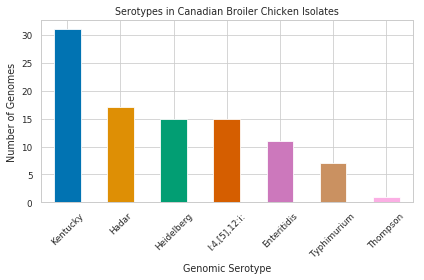

In [627]:
serotype_comparisons['sistr_prediction'].value_counts().plot(kind='bar')
plt.title('Serotypes in Canadian Broiler Chicken Isolates')
plt.ylabel('Number of Genomes')
plt.xticks(rotation=45)
plt.xlabel('Genomic Serotype')
plt.tight_layout()
plt.savefig('analyses/serotyping/serotypes.svg')
plt.savefig('analyses/serotyping/serotypes.pdf')

In [623]:
serotype_comparisons['sistr_prediction'].value_counts()

Kentucky         31
Hadar            17
Heidelberg       15
I:4,[5],12:i:    15
Enteritidis      11
Typhimurium       7
Thompson          1
Name: sistr_prediction, dtype: int64

In [6]:
# set consistent colors for serotype
sero_lut = dict(zip(['Kentucky', 'Hadar', 'Heidelberg', 
                     'I4,[5],12:i:', 'Enteritidis', 
                     'Typhimurium', 'Thompson'], sns.color_palette().as_hex()))
sero_lut

{'Enteritidis': '#cc78bc',
 'Hadar': '#de8f05',
 'Heidelberg': '#029e73',
 'I4,[5],12:i:': '#d55e00',
 'Kentucky': '#0173b2',
 'Thompson': '#fbafe4',
 'Typhimurium': '#ca9161'}

In [7]:
# to assess overall performance lets tabulate the differences
# note this will only accept if its an exact match, no prevaricating between serotypes

def classification_summary(y_true, y_pred, label):
    report = metrics.classification_report(y_true, y_pred, y_true.unique())
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        line = line.split()
        row['class'] = line[0]
        row['precision'] = float(line[1])
        row['recall'] = float(line[2])
        row['f1_score'] = float(line[3])
        row['support'] = float(line[4])
        report_data.append(row)
    
    # get overall metrics
    overall = lines[-2].split()
    row = {'class': 'Overall avg/total',
           'precision': float(overall[3]),
           'recall': float(overall[4]),
           'f1_score': float(overall[5]),
           'support': float(overall[6])}
    
    report_data.append(row)
    df = pd.DataFrame(report_data)
    df['method'] = label
    
    return df

performance_data = []
for column in serotype_comparisons.drop('sistr_prediction', axis=1).columns:  
    classification_report = classification_summary(serotype_comparisons['sistr_prediction'], 
                                                   serotype_comparisons[column], 
                                                   column)
    performance_data.append(classification_report)

performance_data = pd.concat(performance_data)

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


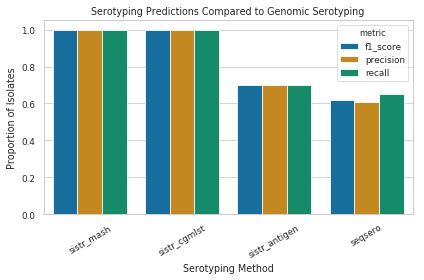

In [629]:
df = pd.melt(performance_data[performance_data['class'] == 'Overall avg/total'], id_vars = ['class', 'method'], var_name='metric')
df = df[df['metric'] != 'support']
g = sns.barplot(x='method', y='value', hue='metric', data = df)
_ = plt.xticks(rotation=30)
plt.ylabel('Proportion of Isolates')
plt.xlabel('Serotyping Method')
plt.title('Serotyping Predictions Compared to Genomic Serotyping')
plt.tight_layout()
plt.savefig('analyses/serotyping/serotypecomparisons.svg')
plt.savefig('analyses/serotyping/serotypecomparisons.pdf')

Overall performance shows that the sistr methods are largely equal, seqsero and `sistr_antigen` have probably suffered by dint of me being strict and only counting correct results when they match exactly instead of giving a list of possibilities. 

In [9]:
df = performance_data[performance_data['class'] != 'Overall avg/total'] 

In [10]:
df = pd.melt(df, id_vars = ['class', 'method'], var_name='metric')
df = df[df['metric'] != 'support']

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


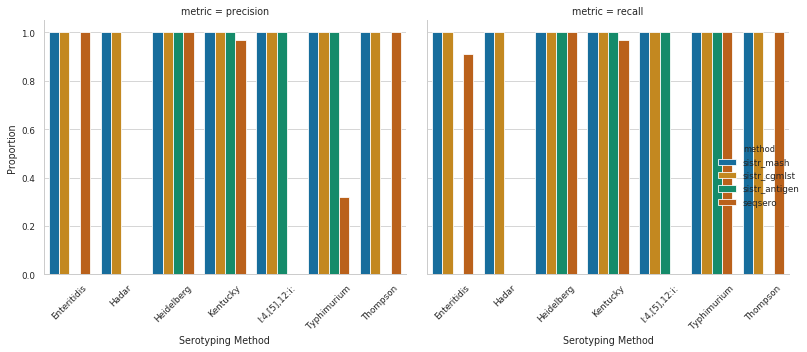

In [19]:
df = df[df['metric'] != 'f1_score']

g = sns.factorplot(kind='bar', x='class', y='value', col='metric', hue='method', data = df)
g.set_xticklabels(rotation=45)
g.set_ylabels('Proportion')
g.set_xlabels('Serotyping Method')
plt.tight_layout()


plt.savefig('analyses/serotyping/serotyping_performance_by_class.svg')
plt.savefig('analyses/serotyping/serotyping_performance_by_class.pdf')

### Summary

Looks like the serotyping performances pretty well regardless of method used. Seqsero and SISTR antigen methods suffer by dint of not being specific enough for the criteria.  It is possible these would improve if we are generous and allow ambiguous serotyping to count as a success if one of the options is the correct serotype e.g. seroseq outputting `Hadar or Istanbul`.

## AMR Analysis

An analysis of the AMR determinants present within the datasets as identified using RGI and the CARD database

### AST results

Parse and explore the AST results from Attiq

In [23]:
# replace their serotyping with our SISTR serotyping

ast_df = pd.read_excel('data/antibiotic_susceptibility_testing/Salmonella_AST_April18,2018..xlsx', sheet_name=1)
ast_df['ID'] = ast_df['ID'].astype(str)
ast_df = ast_df.set_index('ID')
ast_df = ast_df.drop('Serovar', axis=1)
# drop the following two genomes as we don't have genomes for them only AST typing
# 3346 and 3163
ast_df = ast_df.drop(['3346', '3163'])
ast_df['Serotype'] = sistr_df.loc[ast_df.index, 'sistr_prediction']
ast_df['Serotype'] = ast_df['Serotype'].replace('I 4,[5],12:i:-', 'I:4,[5],12:i:')

In [24]:
# set consistent colors for serotype
sero_order = ['Kentucky', 'Hadar', 'Heidelberg', 
                     'I:4,[5],12:i:', 'Enteritidis', 
                     'Typhimurium', 'Thompson']
sero_lut = dict(zip(['Kentucky', 'Hadar', 'Heidelberg', 
                     'I:4,[5],12:i:', 'Enteritidis', 
                     'Typhimurium', 'Thompson'], sns.color_palette().as_hex()))

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")
/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


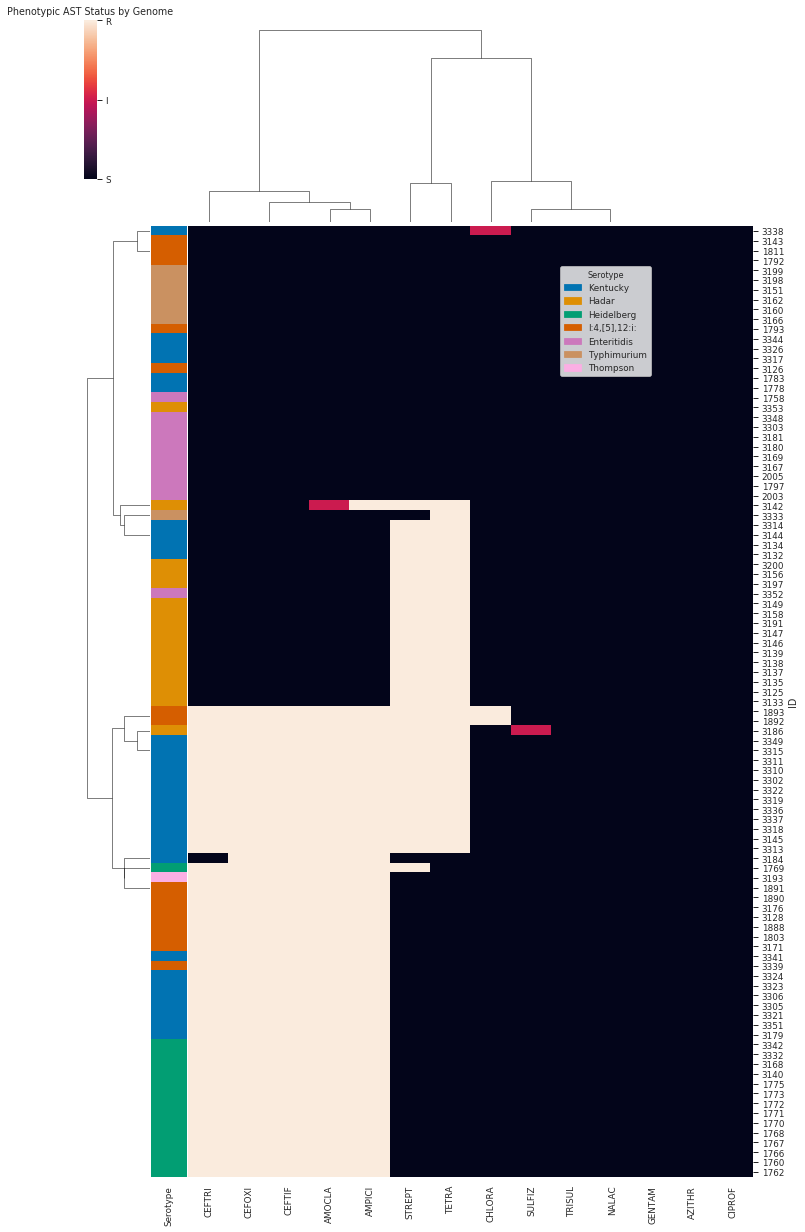

In [630]:
sir_labels = ast_df.loc[:, 'AMOCLA': 'TRISUL']
sir_labels[ast_df == 'S'] = 0
sir_labels[ast_df == 'I'] = 1
sir_labels[ast_df == 'R'] = 2
sir_labels = sir_labels.apply(pd.to_numeric)

sero = ast_df['Serotype'].loc[sir_labels.index]
colors = sero.map(sero_lut)

import matplotlib.patches as mpatches
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in sero_lut.items()]

g = sns.clustermap(sir_labels, row_colors=colors, cbar_kws={'ticks': [0,1,2]}, xticklabels=True, 
                   yticklabels=True, figsize=(12,22))


plt.yticks([0,1,2], ['S', 'I', 'R'])
plt.title("Phenotypic AST Status by Genome")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.65,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
plt.subplots_adjust(bottom=0.15)
plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.tight_layout()
plt.savefig('analyses/ast/astsummaryclustermap.svg')
plt.savefig('analyses/ast/astsummaryclustermap.pdf')

In [744]:
for col in ast_df.drop(['Date Read', 'Serotype'], axis=1):
    print(ast_df.drop('Date Read', axis=1).groupby('Serotype')[col].value_counts())

Serotype       AMOCLA
Enteritidis    S         11
Hadar          S         15
               I          1
               R          1
Heidelberg     R         15
I:4,[5],12:i:  R         10
               S          5
Kentucky       R         21
               S         10
Thompson       R          1
Typhimurium    S          7
Name: AMOCLA, dtype: int64
Serotype       AMPICI
Enteritidis    S         11
Hadar          S         15
               R          2
Heidelberg     R         15
I:4,[5],12:i:  R         10
               S          5
Kentucky       R         21
               S         10
Thompson       R          1
Typhimurium    S          7
Name: AMPICI, dtype: int64
Serotype       AZITHR
Enteritidis    S         11
Hadar          S         17
Heidelberg     S         15
I:4,[5],12:i:  S         15
Kentucky       S         31
Thompson       S          1
Typhimurium    S          7
Name: AZITHR, dtype: int64
Serotype       CEFOXI
Enteritidis    S         11
Hadar          S   

In [771]:
df = pd.melt(ast_df.drop('Date Read', axis=1), id_vars='Serotype').groupby(['Serotype', 'variable'])['value'].value_counts()
df = df.reset_index(level=0).rename(columns={'value': 'count'}).reset_index()

In [789]:
df = pd.melt(ast_df.drop('Date Read', axis=1), id_vars='Serotype').groupby(['Serotype', 'variable'])['value'].nunique()
df = df.reset_index(level=0).rename(columns={'value': 'count'}).reset_index()
df.groupby('Serotype').sum()

,count
Serotype,
Enteritidis,16
Hadar,23
Heidelberg,15
"I:4,[5],12:i:",22
Kentucky,22
Thompson,14
Typhimurium,15


In [795]:
ast_df.drop('Date Read', axis=1).drop_duplicates()['Serotype'].value_counts()

Kentucky         6
Hadar            4
I:4,[5],12:i:    3
Typhimurium      2
Enteritidis      2
Heidelberg       2
Thompson         1
Name: Serotype, dtype: int64

In [740]:
ast_df[(ast_df['CEFOXI'] == 'S') & (ast_df['TETRA'] == 'S')  & (ast_df['CHLORA'] == 'S')]['Serotype'].value_counts()

Enteritidis      10
Typhimurium       6
Kentucky          5
I:4,[5],12:i:     5
Hadar             1
Name: Serotype, dtype: int64

In [731]:
ast_df['Serotype'].value_counts()

Kentucky         31
Hadar            17
Heidelberg       15
I:4,[5],12:i:    15
Enteritidis      11
Typhimurium       7
Thompson          1
Name: Serotype, dtype: int64

Serotype       CEFOXI
Enteritidis    S         11
Hadar          S         16
               R          1
Heidelberg     R         15
I:4,[5],12:i:  R         10
               S          5
Kentucky       R         21
               S         10
Thompson       R          1
Typhimurium    S          7
Name: CEFOXI, dtype: int64

In [ ]:
df = ast_df.drop(["Date Read"], axis=1)

# so we can normalise the counts
total_serovars_in_dataset = ast_df['Serotype'].value_counts()

# tally up the SIR statuses
df = pd.melt(df, id_vars='Serotype', var_name='Antimicrobial', value_name='SIR')
df = df.groupby(['Serotype', 'Antimicrobial', 'SIR']).size().unstack(fill_value=0).reset_index()

norm_df = df.set_index('Serotype').join(total_serovars_in_dataset)

norm_df['S'] = norm_df['S'] / norm_df['Serotype']
norm_df['I'] = norm_df['I'] / norm_df['Serotype']
norm_df['R'] = norm_df['R'] / norm_df['Serotype']

norm_df = norm_df.reset_index()
norm_df = norm_df.drop('Serotype', axis=1)
norm_df = norm_df.rename(columns={'index': 'Serotype'})
norm_df = pd.melt(norm_df, id_vars=['Serotype', 'Antimicrobial'], var_name='SIR', value_name='Proportion of Serovars')

sns.factorplot(data=norm_df, col = 'SIR', col_order = ['S', 'I', 'R'], order = sero_order, row = "Antimicrobial", y="Serotype", x="Proportion of Serovars", kind='bar')
plt.subplots_adjust(bottom=0.02)
plt.savefig('analyses/ast/ast_summary.pdf')
plt.savefig('analyses/ast/ast_summary.svg')

In [30]:
ast_df.drop(['Date Read', 'Serotype'], axis=1).replace('I', 0).replace('R', 1).replace('S', 0).to_csv('analyses/ast/ast_sir_labels.csv')

In [31]:
!R CMD analyses/ast/ast_upset_plot.r
# to plot all the upset plots

/home/fin/miniconda3/envs/AMRtime_analysis/lib/R/bin/Rcmd: line 62: /home/fin/Documents/postdoc/salmonella/full_analysis/aafc_salmonella/analyses/ast/ast_upset_plot.r: No such file or directory


In [32]:
from IPython.display import IFrame
IFrame("analyses/ast/upset_all_ast.pdf", width=800, height=800)

In [33]:
IFrame("analyses/ast/upset_hadar_ast.pdf", width=800, height=800)

In [34]:
IFrame("analyses/ast/upset_heidelberg_ast.pdf", width=800, height=800)

In [35]:
IFrame("analyses/ast/upset_kentucky_ast.pdf", width=800, height=800)

In [36]:
IFrame("analyses/ast/upset_typhimurium_ast.pdf",  width=800, height=800)

In [37]:
IFrame("analyses/ast/upset_enterica_ast.pdf" , width=800, height=800)

### Genotypic AMR Prediction

Summary of the RGI based predictions from the genotypes

In [38]:
"""ast_df = pd.read_excel('data/antibiotic_susceptibility_testing/Salmonella_AST_April18,2018..xlsx', sheet_name=1)
ast_df['ID'] = ast_df['ID'].astype(str)
ast_df = ast_df.set_index('ID')
# drop the following two genomes as we don't have genomes for them only AST typing
# 3346 and 3163
ast_df = ast_df.drop(['3346', '3163'])
ast_df['Serovar'] = sistr_df.loc[ast_df.index, 'serovar']"""


rgi_results = []
missing = []
for assembly_id in ast_df.index:
    rgi_output = glob('analyses/rgi/{}_irida-submission-*.fasta_rgi.txt'.format(assembly_id))
    if len(rgi_output) == 1:
        df = pd.read_csv(rgi_output[0], sep='\t')
        df['ID'] = assembly_id
        rgi_results.append(df)
    elif len(rgi_output) > 1:
        print("Multiple hits")
    else:
        missing.append(assembly_id)

print("Genome with AST but no data downloaded from IRIDA ID:{}".format(missing))
        
rgi_results = pd.concat(rgi_results)
rgi_results = rgi_results.reset_index()
rgi_results = rgi_results.set_index('ID')
rgi_results = rgi_results.drop('index', axis=1)

#Then discard all AST data where we don't have a genome
ast_df = ast_df.drop(missing, axis=0)

Genome with AST but no data downloaded from IRIDA ID:[]


In [865]:
def get_drug_classes_and_families_by_ID(df):
# gather up the drug classes and gene families by ID
# fill na with '' empty string to avoid issues with pd.nan being a float
    drug_class = {}
    gene_family = {}
    for row in df.fillna('').iterrows():
        if row[0] not in drug_class:
            drug_class.update({row[0]: [row[1]['Drug Class']]})
        else:
            drug_class[row[0]].append(row[1]['Drug Class'])
        if row[0] not in gene_family:
            gene_family.update({row[0]: [row[1]['AMR Gene Family']]})
        else:
            gene_family[row[0]].append(row[1]['AMR Gene Family'])


    for key, value in drug_class.items():
        resistances = []
        for drug_list in value:
            for drug in drug_list.split(';'):
                if len(drug) != 0: 
                    resistances.append(drug.strip())

        drug_class[key] = resistances


    for key, value in gene_family.items():
        families = []
        for family_list in value:
            for family in family_list.split(';'):
                families.append(family.strip())

        gene_family[key] = families
        
    return drug_class, gene_family

    
drug_class, gene_family = get_drug_classes_and_families_by_ID(rgi_results)
perfect_drug_class, \
perfect_gene_family = get_drug_classes_and_families_by_ID(rgi_results[rgi_results['Cut_Off']=='Perfect'])

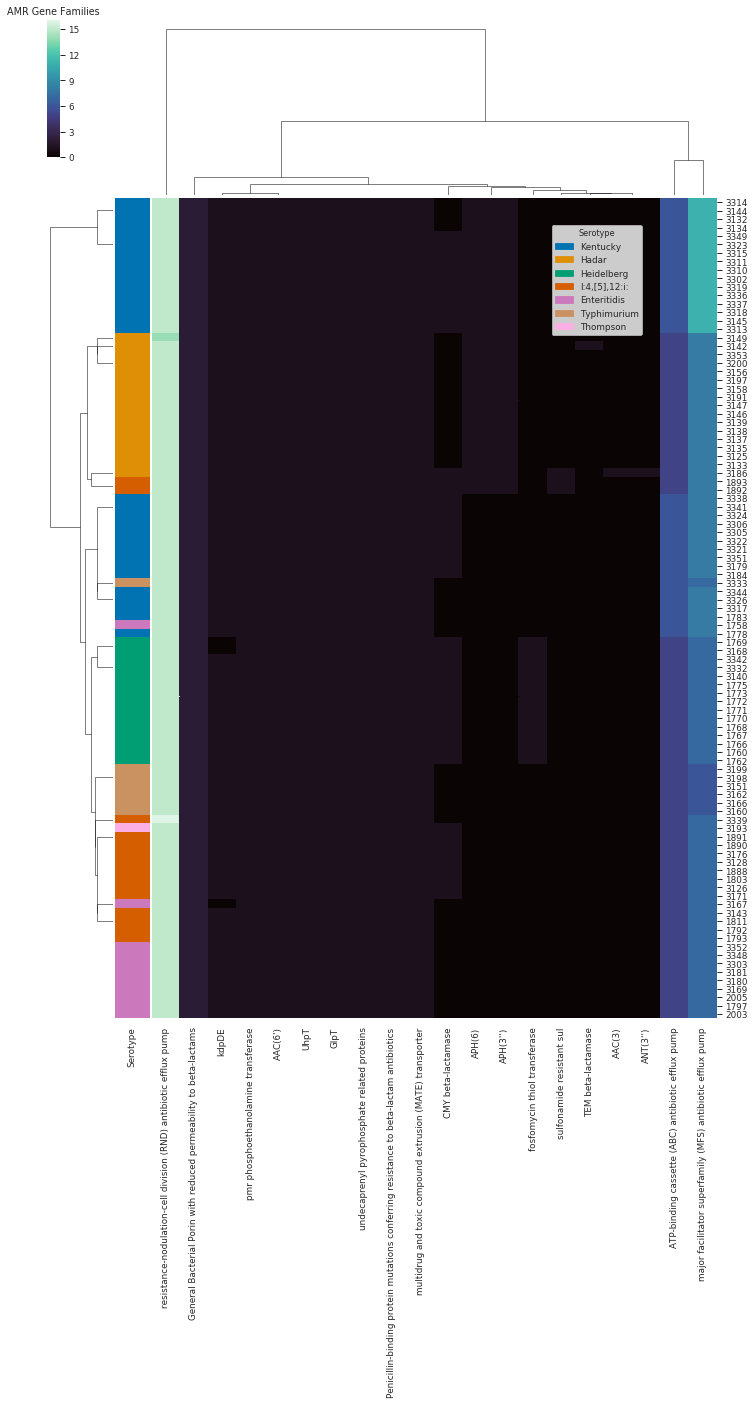

In [885]:
df = get_drug_class_df(gene_family)

sero = ast_df['Serotype'].loc[sir_labels.index]
colors = sero.map(sero_lut)

legend_TN = [mpatches.Patch(color=c, label=l) for l,c in sero_lut.items()]
g = sns.clustermap(df, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')
plt.title("AMR Gene Families")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.7,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.25)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
#df['Serotype'] = ast_df['Serotype'].loc[df.index]

#df = pd.melt(df, id_vars='Serotype', var_name='AMR Gene Family', value_name='Gene Count')
plt.savefig('analyses/rgi/familymap.pdf')

In [886]:
sero_lut

{'Enteritidis': '#cc78bc',
 'Hadar': '#de8f05',
 'Heidelberg': '#029e73',
 'I:4,[5],12:i:': '#d55e00',
 'Kentucky': '#0173b2',
 'Thompson': '#fbafe4',
 'Typhimurium': '#ca9161'}

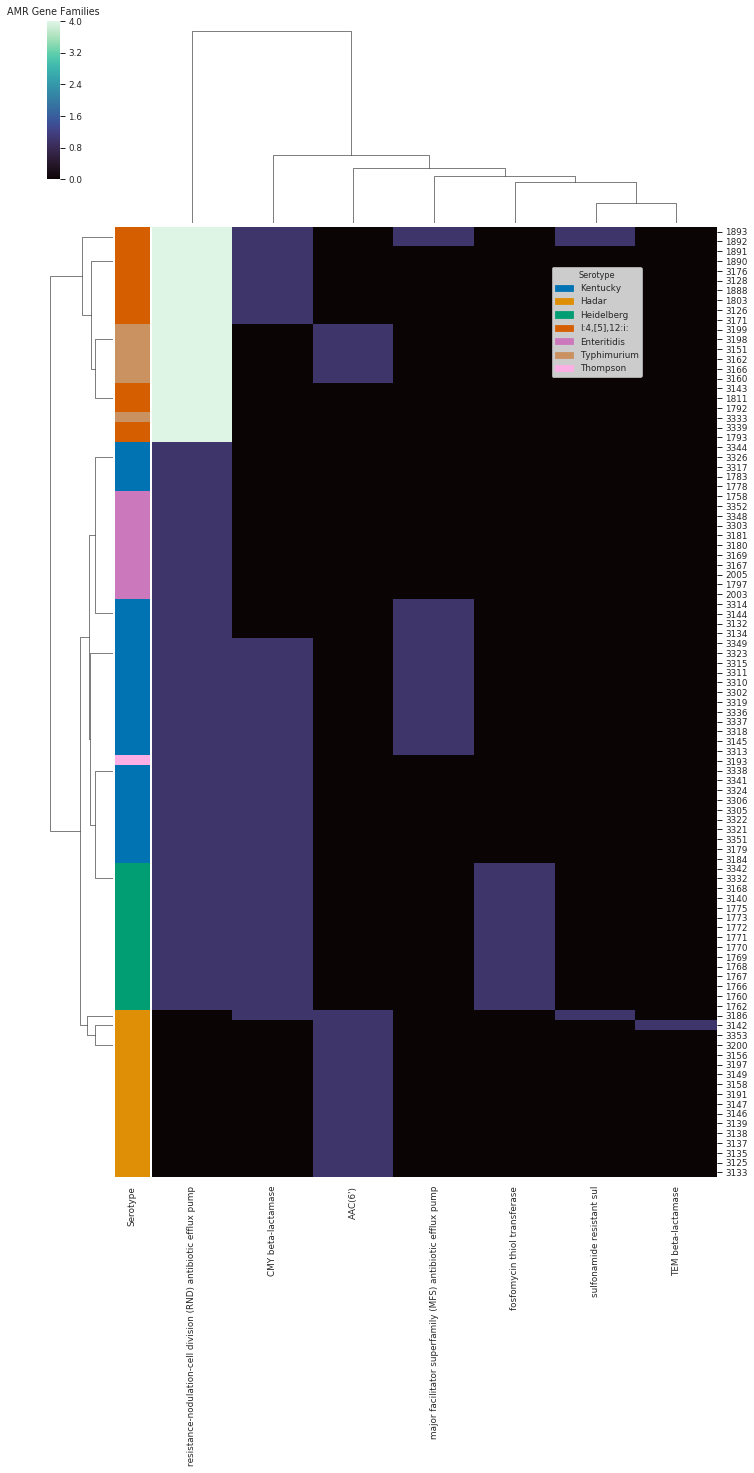

In [884]:
df = get_drug_class_df(perfect_gene_family)

sero = ast_df['Serotype'].loc[sir_labels.index]
colors = sero.map(sero_lut)

legend_TN = [mpatches.Patch(color=c, label=l) for l,c in sero_lut.items()]
g = sns.clustermap(df, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')
plt.title("AMR Gene Families")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.7,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
#df['Serotype'] = ast_df['Serotype'].loc[df.index]

#df = pd.melt(df, id_vars='Serotype', var_name='AMR Gene Family', value_name='Gene Count')
plt.savefig('analyses/rgi/perfectfamilymap.pdf')

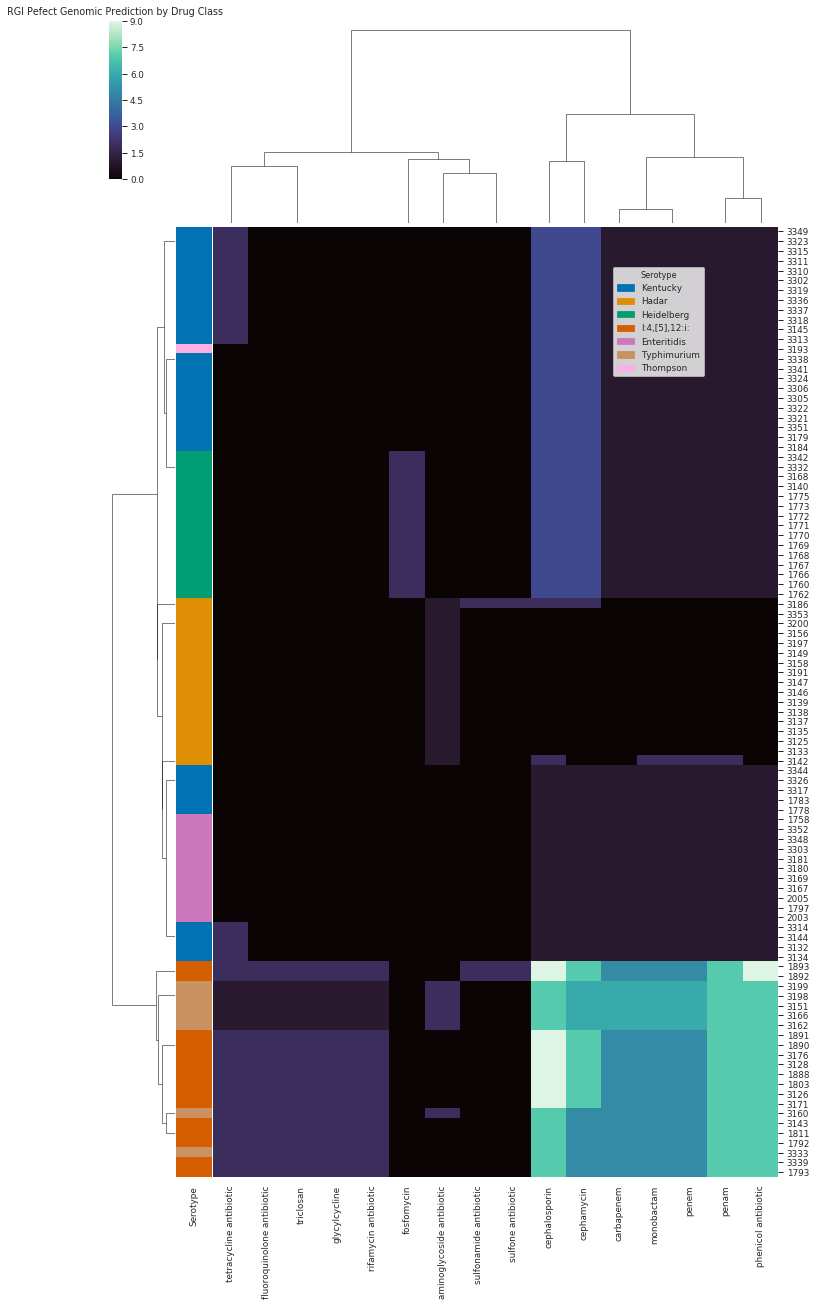

In [796]:
def get_drug_class_df(drug_class_dict):
    all_drug_classes = set()
    for drug_set in list(drug_class_dict.values()):
        all_drug_classes = all_drug_classes.union(drug_set)

    df = pd.DataFrame(index=drug_class_dict.keys(), columns=all_drug_classes)
    df = df.fillna(0)
    for genome_id, drug_resistances in drug_class_dict.items():
        for drug in drug_resistances:
            df.loc[genome_id, drug] += 1
    
    return df

df = get_drug_class_df(perfect_drug_class)

sero = ast_df['Serotype'].loc[sir_labels.index]
colors = sero.map(sero_lut)

legend_TN = [mpatches.Patch(color=c, label=l) for l,c in sero_lut.items()]
g = sns.clustermap(df, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')
#_ = plt.ylabel('S                      I                    R')
plt.title("RGI Pefect Genomic Prediction by Drug Class")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.7,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


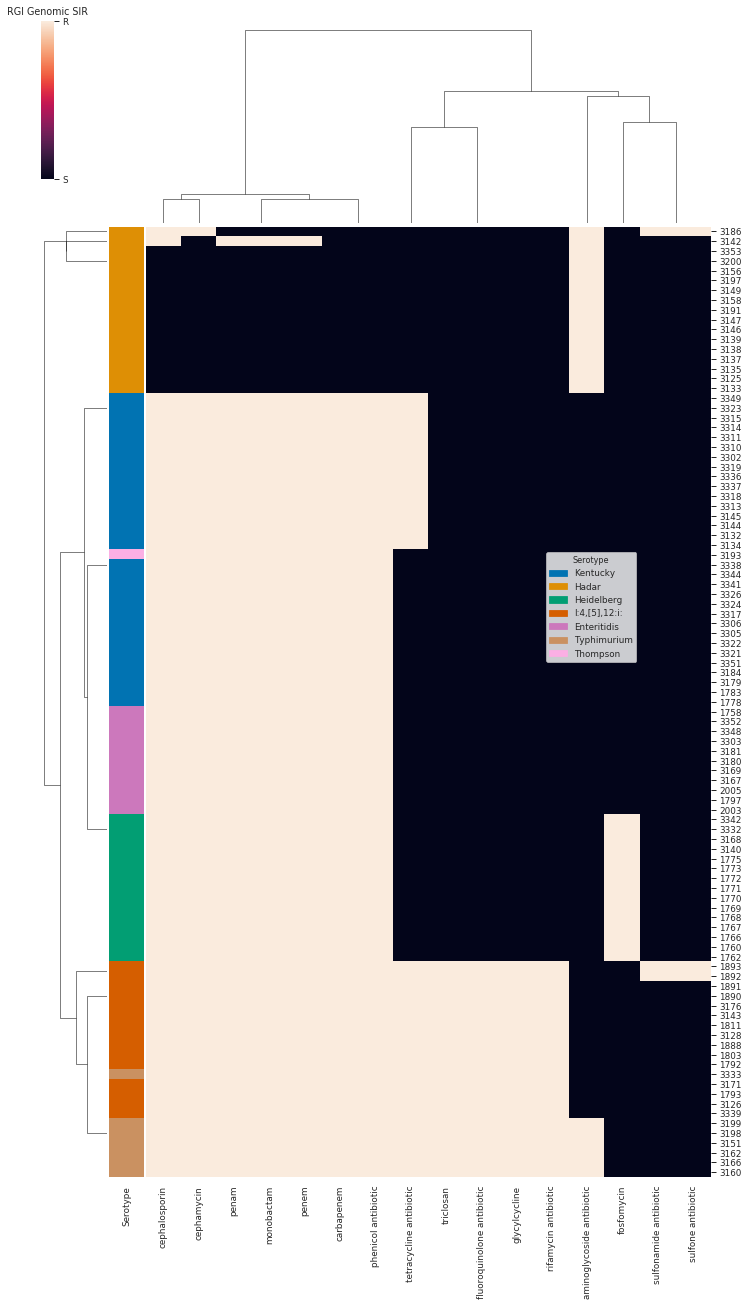

In [169]:
# let's get a binary plot
df = get_drug_class_df({k: set(v) for k,v in perfect_drug_class.items()})
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in sero_lut.items()]

sero = ast_df['Serotype'].loc[sir_labels.index]
colors = sero.map(sero_lut)

g = sns.clustermap(df, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cbar_kws={'ticks': [0,1,2]})

plt.yticks([0,1], ['S', 'R'])
#_ = plt.ylabel('S                                          R')
plt.title("RGI Genomic SIR")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.7,0.6),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

#save_figure('amr/rgi_perfect_drug_class_binary')

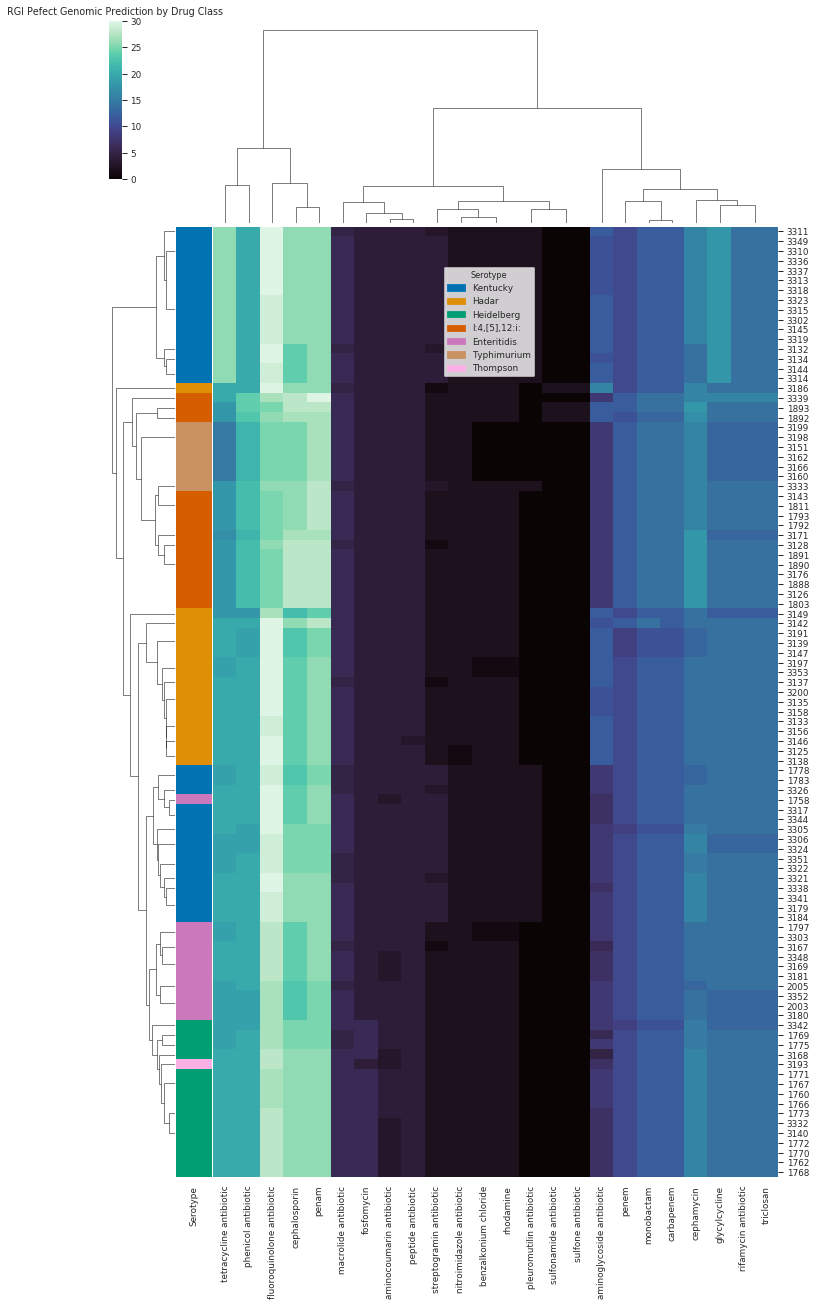

In [170]:
df = get_drug_class_df(drug_class)
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in sero_lut.items()]

sero = ast_df['Serotype'].loc[sir_labels.index]
colors = sero.map(sero_lut)

g = sns.clustermap(df, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')

plt.title("RGI Pefect Genomic Prediction by Drug Class")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.4,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
#save_figure('amr/rgi_drug_class.pdf')

In [824]:
rgi_encoded = pd.DataFrame(index=ast_df.index, columns=set(rgi_results['Best_Hit_ARO'].values)).fillna(0)
rgi_encoded_perfect = pd.DataFrame(index=ast_df.index, columns=set(rgi_results[rgi_results['Cut_Off']=='Perfect']['Best_Hit_ARO'].values)).fillna(0) 
rgi_encoded_strict = pd.DataFrame(index=ast_df.index, columns=set(rgi_results[rgi_results['Cut_Off']=='Strict']['Best_Hit_ARO'].values)).fillna(0) 

for genome_id, rgi_data in rgi_results.iterrows():
    if rgi_data['Cut_Off'] == 'Perfect':
        rgi_encoded_perfect.loc[genome_id, rgi_data['Best_Hit_ARO']] += 1
        rgi_encoded.loc[genome_id, rgi_data['Best_Hit_ARO']] += 1
    elif rgi_data['Cut_Off'] == 'Strict':
        rgi_encoded_strict.loc[genome_id, rgi_data['Best_Hit_ARO']] += 1
        rgi_encoded.loc[genome_id, rgi_data['Best_Hit_ARO']] += 1
    else:
        rgi_encoded.loc[genome_id, rgi_data['Best_Hit_ARO']] += 1
        

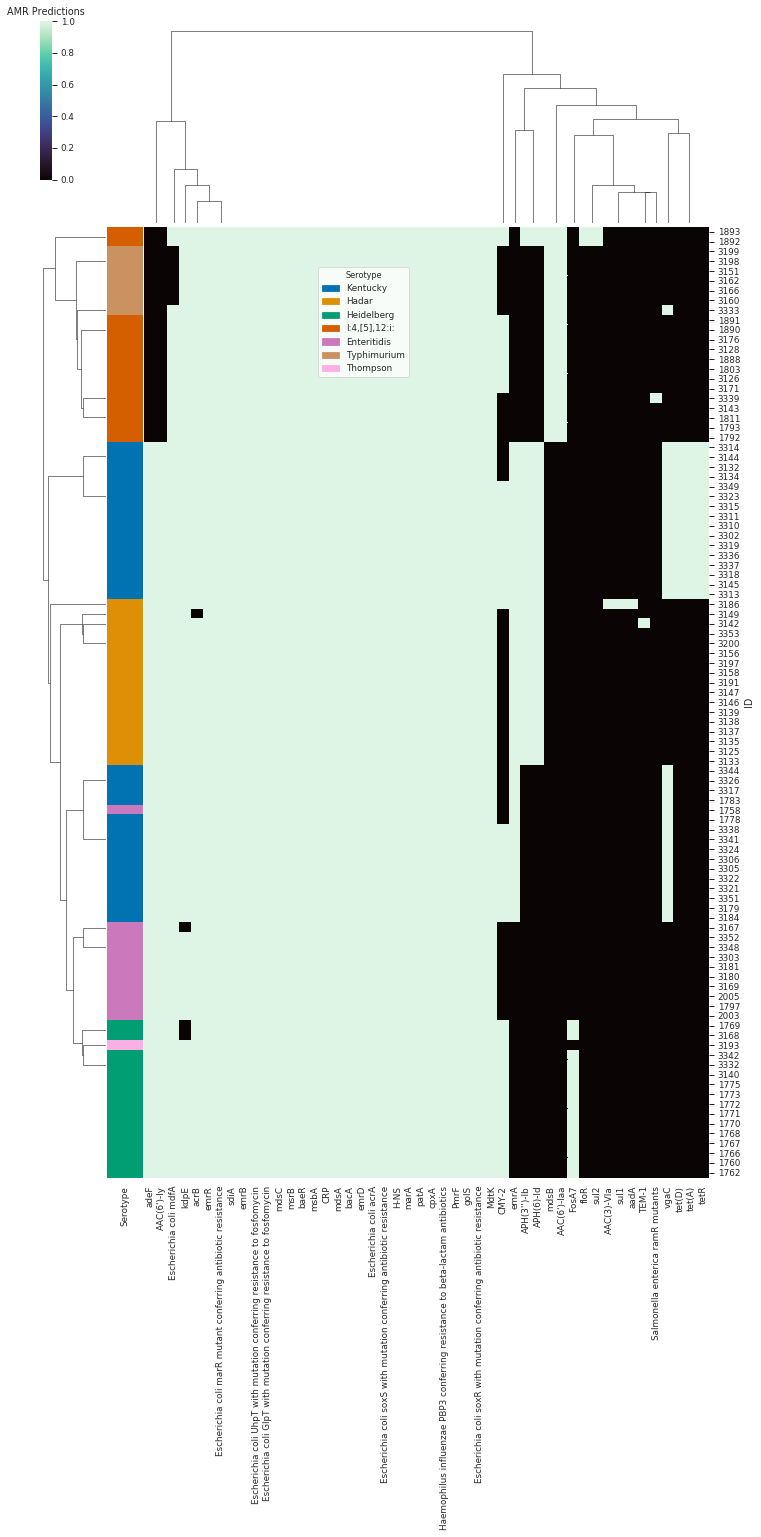

In [172]:
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in sero_lut.items()]

g = sns.clustermap(rgi_encoded, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')

plt.title("AMR Predictions")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.3,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
#save_figure('amr/aro_clustermap')

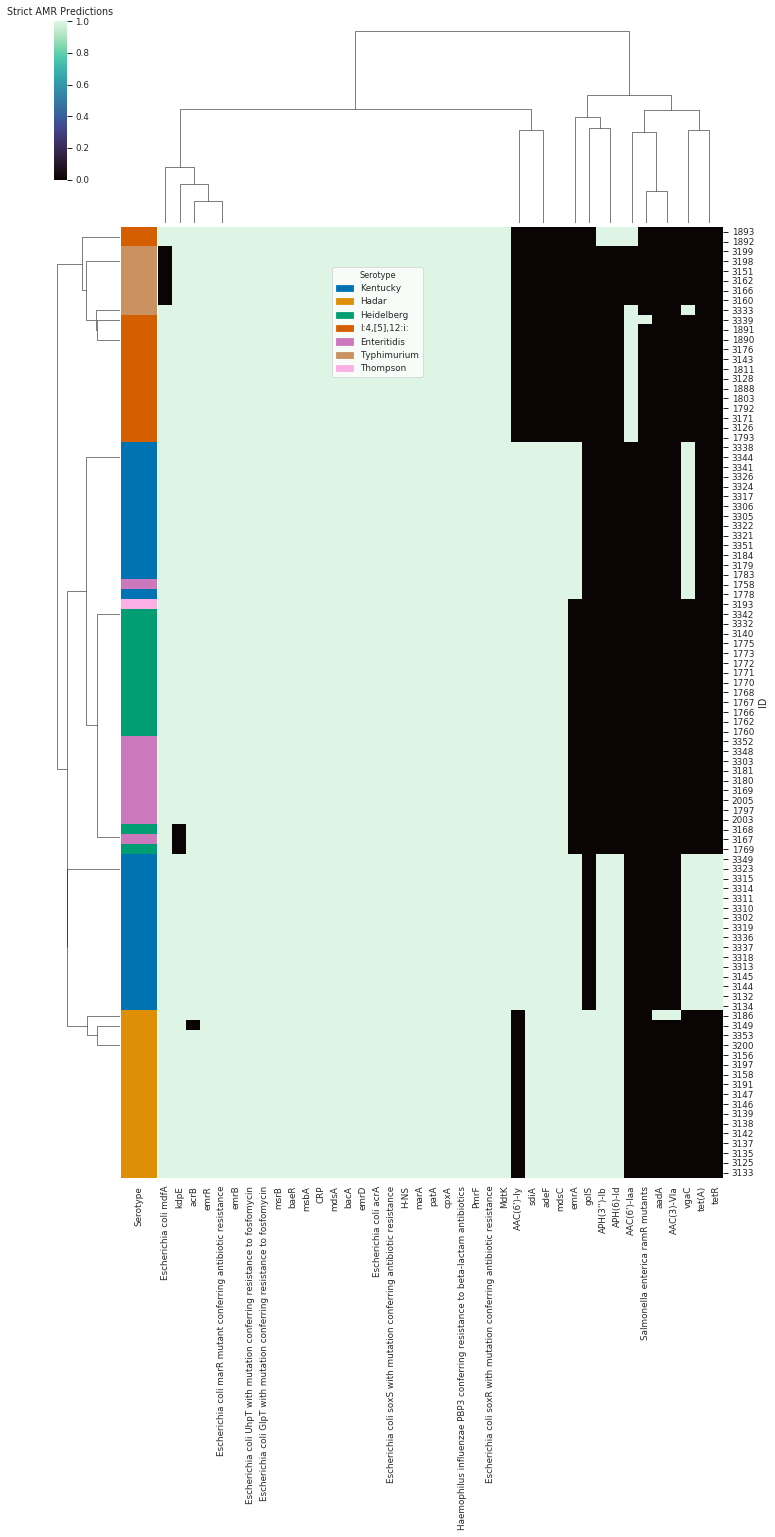

In [825]:
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in sero_lut.items()]

g = sns.clustermap(rgi_encoded_strict, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')

plt.title("Strict AMR Predictions")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.3,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
#save_figure('amr/aro_clustermap')

In [173]:
rgi_encoded_perfect['Serotype'] = ast_df['Serotype'].loc[rgi_encoded_perfect.index]

# select unique perfect RGI distributions for more in-depth analysis
with open('analyses/pangenome/anvio_subsample/link_genomes.sh', 'w') as fh: 
    for genome in rgi_encoded_perfect.drop_duplicates().index:
        fh.write('ln -s ../../../data/genomes/{}*\n'.format(genome))
        
with open('analyses/pangenome/anvio_subsample/serotypes.tsv', 'w') as out_fh:
    with open('analyses/pangenome/anvio_subsample/genomes.tsv', 'w') as fh: 
        dbs = """1760_irida-submission-4658.db  3125_irida-submission-4766.db  3145_irida-submission-4824.db  3193_irida-submission-7564.db
        1778_irida-submission-4656.db  3126_irida-submission-4768.db  3166_irida-submission-7409.db  3333_irida-submission-7381.db
        1797_irida-submission-4682.db  3132_irida-submission-4774.db  3179_irida-submission-7552.db  3339_irida-submission-7440.db
        1893_irida-submission-4751.db  3142_irida-submission-4815.db  3186_irida-submission-7560.db""".split()
    
        fh.write('name\tcontigs_db_path\n')
        out_fh.write('name\tserovars\n')
        for db in dbs:
            name = db.split('_')[0]
            serotype = rgi_encoded_perfect['Serotype'].loc[name]
            fh.write('{}_{}\t{}\n'.format(serotype.replace(',', '_').replace('[', '').replace(']', '').replace(':', ''), name, db))
            out_fh.write('{}_{}\t{}\n'.format(serotype.replace(',', '_').replace('[', '').replace(']', '').replace(':', ''), name, serotype))

        
    
rgi_encoded_perfect = rgi_encoded_perfect.drop('Serotype', axis=1)

In [932]:
pd.__version__

'0.22.0'

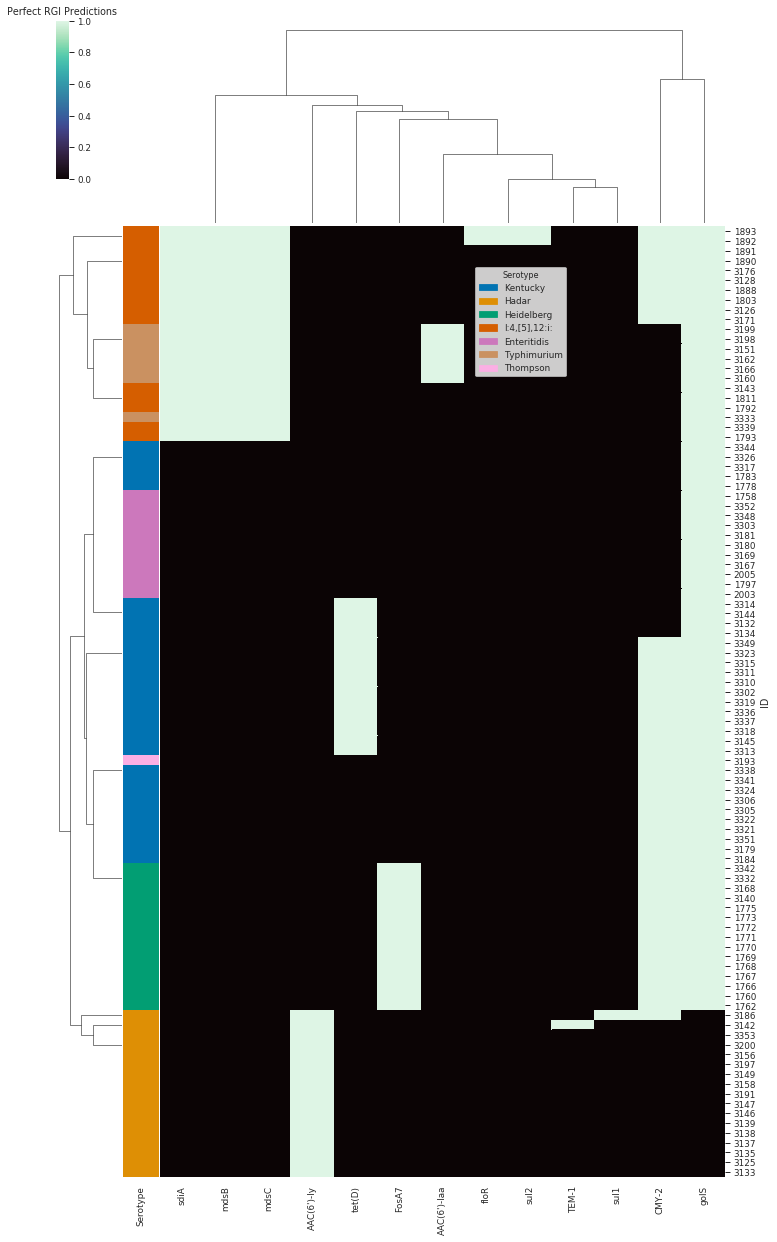

In [797]:
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in sero_lut.items()]



g = sns.clustermap(rgi_encoded_strict, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')

plt.title("Perfect RGI Predictions")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.55,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.savefig('analyses/rgi/perfectpredictions.pdf')
plt.savefig('analyses/rgi/perfectpredictions.svg')

In [848]:
rgi_encoded_perfect['serotype'] = ast_df['Serotype'].loc[rgi_encoded_perfect.index]

for value in rgi_encoded_perfect['serotype'].unique():
    print(value, rgi_encoded_perfect[(rgi_encoded_perfect['serotype'] == value)].drop_duplicates().shape)

Enteritidis (1, 14)
Hadar (3, 14)
Heidelberg (1, 14)
Kentucky (4, 14)
I:4,[5],12:i: (3, 14)
Typhimurium (2, 14)
Thompson (1, 14)


In [851]:
rgi_encoded_perfect[rgi_encoded_perfect['serotype'] == 'I:4,[5],12:i:']

,CMY-2,TEM-1,FosA7,tet(D),floR,mdsB,mdsC,AAC(6')-Iaa,sul2,golS,sdiA,sul1,AAC(6')-Iy,serotype
ID,,,,,,,,,,,,,,
3126,1,0,0,0,0,1,1,0,0,1,1,0,0,"I:4,[5],12:i:"
3339,0,0,0,0,0,1,1,0,0,1,1,0,0,"I:4,[5],12:i:"
1793,0,0,0,0,0,1,1,0,0,1,1,0,0,"I:4,[5],12:i:"
3171,1,0,0,0,0,1,1,0,0,1,1,0,0,"I:4,[5],12:i:"
1792,0,0,0,0,0,1,1,0,0,1,1,0,0,"I:4,[5],12:i:"
1803,1,0,0,0,0,1,1,0,0,1,1,0,0,"I:4,[5],12:i:"
1888,1,0,0,0,0,1,1,0,0,1,1,0,0,"I:4,[5],12:i:"
1893,1,0,0,0,1,1,1,0,1,1,1,0,0,"I:4,[5],12:i:"
3128,1,0,0,0,0,1,1,0,0,1,1,0,0,"I:4,[5],12:i:"


In [847]:
df

,CMY-2,TEM-1,FosA7,tet(D),floR,mdsB,mdsC,AAC(6')-Iaa,sul2,golS,sdiA,sul1,AAC(6')-Iy,serotype
ID,,,,,,,,,,,,,,
1778,0,0,0,0,0,0,0,0,0,1,0,0,0,Kentucky
3132,0,0,0,1,0,0,0,0,0,1,0,0,0,Kentucky
3145,1,0,0,1,0,0,0,0,0,1,0,0,0,Kentucky
3179,1,0,0,0,0,0,0,0,0,1,0,0,0,Kentucky


In [831]:
rgi_encoded.sum()[rgi_encoded.sum() == 97]

Escherichia coli soxR with mutation conferring antibiotic resistance            97
MdtK                                                                            97
golS                                                                            97
PmrF                                                                            97
Haemophilus influenzae PBP3 conferring resistance to beta-lactam antibiotics    97
cpxA                                                                            97
patA                                                                            97
marA                                                                            97
H-NS                                                                            97
Escherichia coli soxS with mutation conferring antibiotic resistance            97
Escherichia coli acrA                                                           97
emrD                                                                            97
bacA

In [49]:
drug_class_translation = {'AMOCA':  ['penam'],
                          'AMPICI': ['penam'],
                          'AZITHR': ['macrolide antibiotic'],
                          'CEFOXI': ['cephamycin'],
                          'CEFTIF': ['cephalosporin'],
                          'CEFTRI': ['cephalosporin'],
                          'CHLORA': ['phenicol antibiotic'],
                          'CIPROF': ['fluoroquinolone antibiotic'],
                          'GENTAM': ['aminoglycoside antibiotic'],
                          'NALAC':  ['fluoroquinolone antibiotic'],
                          'STREPT': ['aminoglycoside antibiotic'],
                          'SULFIZ': ['sulfonamide antibiotic'],
                          'TETRA':  ['tetracycline antibiotic'],
                          'TRISUL': ['sulfonamide antibiotic', 'diaminopyrimidine antibiotic']}

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


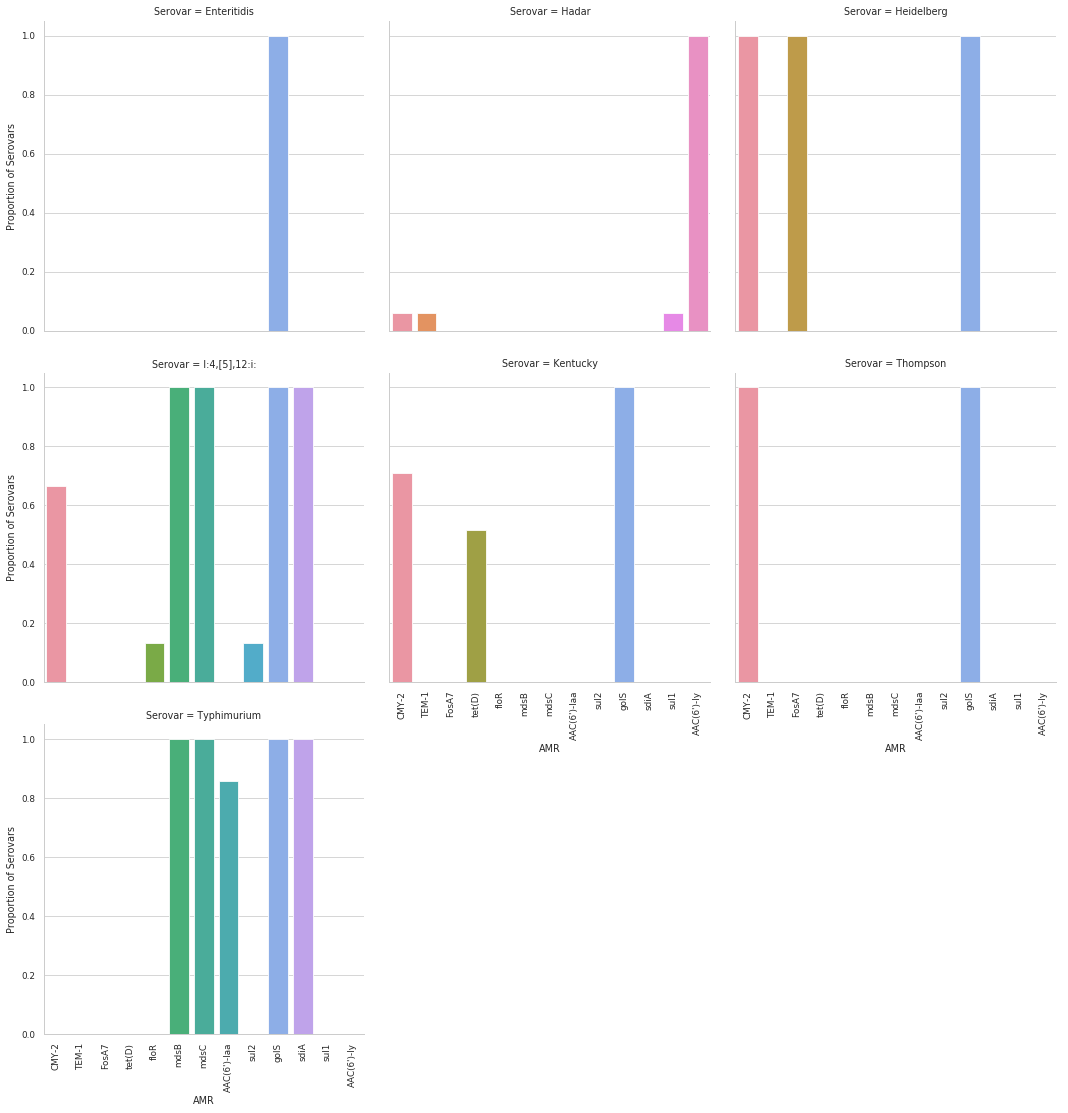

In [51]:
# normalise
rgi_encoded_perfect['Serotype'] = ast_df.loc[rgi_encoded_perfect.index, 'Serotype']
df = rgi_encoded_perfect.groupby("Serotype").sum()
df = df.transpose().div(total_serovars_in_dataset, axis=1).transpose()
df = pd.melt(df.reset_index(), id_vars = 'index')
df = df.rename(columns={'index': 'Serovar', 'variable': 'AMR', 'value': 'Proportion of Serovars'})

g = sns.factorplot(data = df, x='AMR', col='Serovar', col_wrap=3, y="Proportion of Serovars", kind='bar')
g.set_xticklabels(rotation=90)
#save_figure('amr/perfect_rgi_by_serovar')
plt.savefig('analyses/rgi/perfect_predictions_by_serovar.pdf')
plt.savefig('analyses/rgi/perfect_predictions_by_serovar.svg')

### Comparing Genotyping to AST

#### Assessing Genotype to Phenotype by FDA standards

Essential Agreement (EA): Agreement within plus or minus one two-fold dilution of reference MIC;

Category Agreement (CA): Agreement of interpretive results (Susceptible (S), Intermediate (I), or Resistant (R));

major discrepancy (maj): The reference category result is S and the new method result is R; and very major discrepancy; 
and (vmj): The reference category result is R and the new method result is S.

In [54]:
# from the card database assuming nalac is nalidixic acid
drug_class_translation = {'AMOCLA':  ['penam'],
                          'AMPICI': ['penam'],
                          'AZITHR': ['macrolide antibiotic'],
                          'CEFOXI': ['cephamycin'],
                          'CEFTIF': ['cephalosporin'],
                          'CEFTRI': ['cephalosporin'],
                          'CHLORA': ['phenicol antibiotic'],
                          'CIPROF': ['fluoroquinolone antibiotic'],
                          'GENTAM': ['aminoglycoside antibiotic'],
                          'NALAC':  ['fluoroquinolone antibiotic'],
                          'STREPT': ['aminoglycoside antibiotic'],
                          'SULFIZ': ['sulfonamide antibiotic'],
                          'TETRA':  ['tetracycline antibiotic'],
                          'TRISUL': ['sulfonamide antibiotic', 'diaminopyrimidine antibiotic']}

# get reverse lookup
drug_class_translation_rev = {}
for key, value in drug_class_translation.items():
    for rgi_drug in value:
        if rgi_drug not in drug_class_translation_rev:
            drug_class_translation_rev.update({rgi_drug : [key]})
        else:
            drug_class_translation_rev[rgi_drug].append(key)


In [55]:
rgi_sir = pd.DataFrame(index=ast_df.index, columns=ast_df.columns)
rgi_sir = rgi_sir.drop('Date Read', axis=1)
rgi_sir['Serotype'] = ast_df.loc[rgi_sir.index, 'Serotype']



df = rgi_results
for row in df.iterrows():
    ix = row[0]
    data = row[1]
    if type(data['Drug Class']) == float:
        print(data['Best_Hit_ARO'], ' missing drug class information')
        data['Drug Class'] = ''
    drug_classes = [x.strip() for x in data['Drug Class'].split(';')]
    for drug in drug_classes:
        if drug in drug_class_translation_rev:
            for ast_class in drug_class_translation_rev[drug]:
                rgi_sir.loc[ix,ast_class] = 'R'
        # add drug classes not in the ast 
        else:
            if drug not in rgi_sir.columns:
                rgi_sir[drug] = np.nan
                rgi_sir.loc[ix, drug] = 'R'
            else:
                rgi_sir.loc[ix, drug] = 'R'
                
# genotypically all the missing are 'S'
rgi_sir = rgi_sir.fillna('S')

emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
emrD  missing drug class information
e

In [56]:
rgi_sir_perfect = pd.DataFrame(index=ast_df.index, columns=ast_df.columns)
rgi_sir_perfect = rgi_sir_perfect.drop('Date Read', axis=1)
rgi_sir_perfect['Serotype'] = ast_df.loc[rgi_sir_perfect.index, 'Serotype']


df = rgi_results[rgi_results['Cut_Off'] == 'Perfect']
for row in df.iterrows():
    ix = row[0]
    data = row[1]
    
    drug_classes = [x.strip() for x in data['Drug Class'].split(';')]
    for drug in drug_classes:
        if drug in drug_class_translation_rev:
            for ast_class in drug_class_translation_rev[drug]:
                rgi_sir_perfect.loc[ix,ast_class] = 'R'
        # add drug classes not in the ast 
        else:
            if drug not in rgi_sir_perfect.columns:
                rgi_sir_perfect[drug] = np.nan
                rgi_sir_perfect.loc[ix, drug] = 'R'
            else:
                rgi_sir_perfect.loc[ix, drug] = 'R'
                
# genotypically all the missing are 'S'
rgi_sir_perfect = rgi_sir_perfect.fillna('S')

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/matplotlib/colorbar.py:217: UserWarning: Use the colorbar set_ticks() method instead.
  warnings.warn("Use the colorbar set_ticks() method instead.")


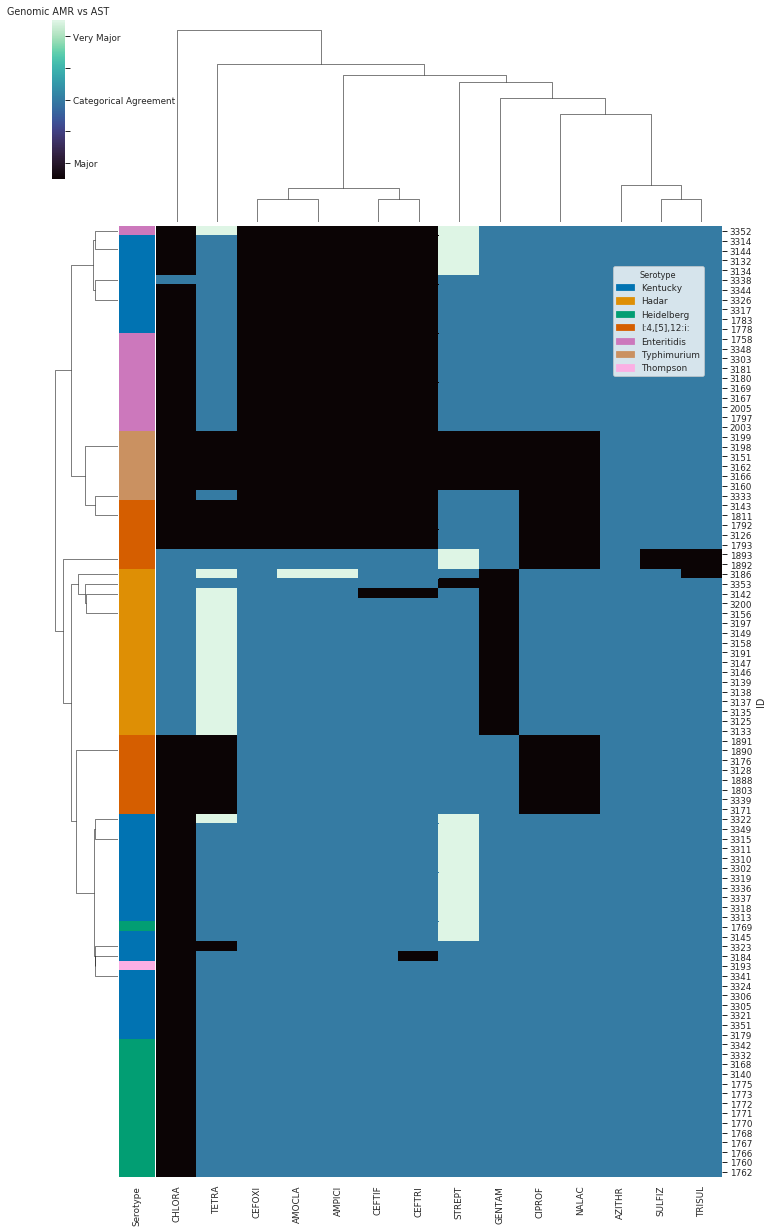

In [924]:
legend_TN = [mpatches.Patch(color=c, label=l) for l,c in sero_lut.items()]
df = ast_df.drop(['Date Read', 'Serotype'], axis=1).replace('I', 1).replace('R', 1).replace('S', 0) - rgi_sir_perfect.loc[:, drug_class_translation.keys()].replace('R', 1).replace('S', 0)

g = sns.clustermap(df, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')
plt.yticks([-1, 1, 0], ['Major', '', 'Categorical Agreement', '', 'Very Major'])

plt.title("Genomic AMR vs AST")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.8,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.savefig('analyses/rgi/errormap.pdf')
plt.savefig('analyses/rgi/errormap.svg')

In [ ]:
ast is R = 1 genome is R = 1 = 0 CA
             genome is S = 0 = 1 Very Major
ast is S = 0 genome is S = 0 = 0 CA
            genome is R = 1 = -1 Major

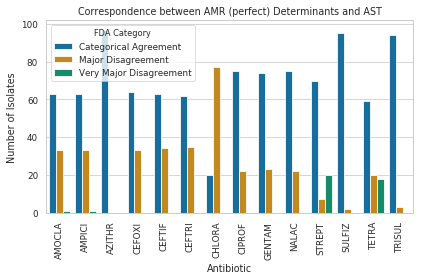

In [977]:
df = ast_df.drop(['Date Read', 'Serotype'], axis=1).replace('I', 1).replace('R', 1).replace('S', 0) - rgi_sir_perfect.loc[:, drug_class_translation.keys()].replace('R', 1).replace('S', 0)

preds = []
for drug in df:
    preds.append(df[drug].value_counts())

df = pd.concat(preds, axis=1).fillna(0).rename(index={-1: "Major Disagreement", 0: "Categorical Agreement", 1: "Very Major Disagreement"})
df = df.reset_index().rename(columns={'index': "FDA Category"})
df = pd.melt(df, id_vars='FDA Category', var_name='Antibiotic', value_name='Count')
sns.barplot(x='Antibiotic', y='Count', hue='FDA Category', hue_order=["Categorical Agreement", "Major Disagreement", "Very Major Disagreement"], data = df)
plt.title('Correspondence between AMR (perfect) Determinants and AST')
plt.ylabel("Number of Isolates")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('analyses/rgi/fdadrugperfect.pdf')

In [981]:
df = ast_df.drop(['Date Read', 'Serotype'], axis=1).replace('I', 1).replace('R', 1).replace('S', 0) - rgi_sir_perfect.loc[:, drug_class_translation.keys()].replace('R', 1).replace('S', 0)

preds = []
for drug in df:
    preds.append(df[drug].value_counts())

df = pd.concat(preds, axis=1).fillna(0).rename(index={-1: "Major Disagreement", 0: "Categorical Agreement", 1: "Very Major Disagreement"})
df = df.reset_index().rename(columns={'index': "FDA Category"})
df = pd.melt(df, id_vars='FDA Category', var_name='Antibiotic', value_name='Count')

df[df['Antibiotic'] == 'CHLORA']

,FDA Category,Antibiotic,Count
18,Major Disagreement,CHLORA,77.0
19,Categorical Agreement,CHLORA,20.0
20,Very Major Disagreement,CHLORA,0.0


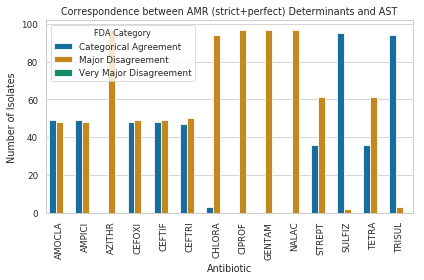

In [927]:
df = ast_df.drop(['Date Read', 'Serotype'], axis=1).replace('I', 1).replace('R', 1).replace('S', 0) - rgi_sir.loc[:, drug_class_translation.keys()].replace('R', 1).replace('S', 0)

preds = []
for drug in df:
    preds.append(df[drug].value_counts())

df = pd.concat(preds, axis=1).fillna(0).rename(index={-1: "Major Disagreement", 0: "Categorical Agreement", 1: "Very Major Disagreement"})
df = df.reset_index().rename(columns={'index': "FDA Category"})
df = pd.melt(df, id_vars='FDA Category', var_name='Antibiotic', value_name='Count')
sns.barplot(x='Antibiotic', y='Count', hue='FDA Category', hue_order=["Categorical Agreement", "Major Disagreement", "Very Major Disagreement"], data = df)
plt.title('Correspondence between AMR (strict+perfect) Determinants and AST')
plt.ylabel("Number of Isolates")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig('analyses/rgi/fdadrug.pdf')

In [901]:
def tally_FDA(rgi_df, ast_df):
    drugs = ['AMOCLA', 'AMPICI', 'AZITHR', 'CEFOXI',
       'CEFTIF', 'CEFTRI', 'CHLORA', 'CIPROF', 'GENTAM', 'NALAC', 'STREPT',
       'SULFIZ', 'TETRA', 'TRISUL']
    fda_perf = pd.DataFrame(index=ast_df.index, columns = ['Categorical Agreement',
                                                           'Major Disagreement',
                                                           'Very Major Disagreement'])
    fda_perf = fda_perf.fillna(0)
    fda_perf['Serovar'] = ast_df['Serotype']
    
    rgi_df = rgi_df.loc[:, drugs]
    ast_df = ast_df.drop('Date Read', axis=1).loc[:, drugs]
    
    # as we aren't predicting 'I'
    ast_df = ast_df.replace('I', 'R')
    
    # to just go over the cols with ast results
    for ix, ast in ast_df.loc[:, drugs].iterrows():
        for drug, sir in ast.iteritems():
            if sir == rgi_df.loc[ix, drug]:
                fda_perf.loc[ix, 'Categorical Agreement'] += 1 
            elif sir == 'S' and rgi_df.loc[ix, drug] == 'R':
                fda_perf.loc[ix, 'Major Disagreement'] += 1
            elif sir == 'R' and rgi_df.loc[ix, drug] == 'S':
                fda_perf.loc[ix, 'Very Major Disagreement'] += 1
            else:
                assert False
    return fda_perf

fda_perf = tally_FDA(rgi_sir, ast_df) 
fda_perf_perfect = tally_FDA(rgi_sir_perfect, ast_df)

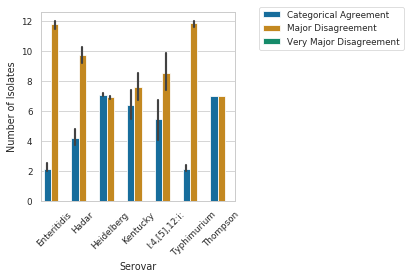

In [929]:
df = pd.melt(fda_perf, id_vars='Serovar', var_name='FDA Category', value_name='Count')
sns.barplot(data = df, x='Serovar', y='Count', hue='FDA Category')
_ = plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.1, 1.05))
#plt.title('Performance of Genomic AMR against AST')
plt.ylabel('Number of Isolates')
#save_figure('amr/fda_rgi_amr')
plt.tight_layout()
plt.savefig('analyses/rgi/fdaamr.pdf')

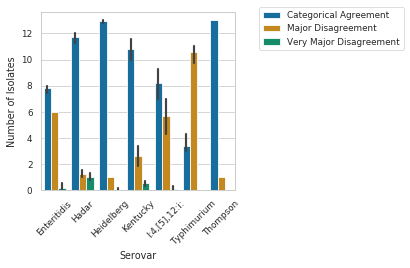

In [930]:
df = pd.melt(fda_perf_perfect, id_vars='Serovar', var_name='FDA Category', value_name='Count')
sns.barplot(data = df, x='Serovar', y='Count', hue='FDA Category')
_ = plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.1, 1.05))
#plt.title('Performance of Genomic AMR (Perfect) against AST')

plt.ylabel('Number of Isolates')
#save_figure('amr/fda_rgi_amr_perfect')
plt.tight_layout()
_ = plt.xticks(rotation=45)
plt.savefig('analyses/rgi/fdaamrperfect.pdf')

In [893]:
fda_perf

,Categorical Agreement,Major Disagreement,Very Major Disagreement,Serovar
ID,,,,
1797,2,12,0,Enteritidis
2003,2,12,0,Enteritidis
2005,2,12,0,Enteritidis
3167,2,12,0,Enteritidis
3169,2,12,0,Enteritidis
3180,2,12,0,Enteritidis
3181,2,12,0,Enteritidis
3303,2,12,0,Enteritidis
3348,2,12,0,Enteritidis


So relatively good but with 'strict' its basically resistant to everything therefore the no vmaj. Perfect seems to be more reasonable.  Interesting that Typhmimurium and Enteriditis are so bad even with perfect cut_off.

In [60]:
print(rgi_sir_perfect.columns)
print(rgi_sir.columns)

Index(['AMOCLA', 'AMPICI', 'AZITHR', 'CEFOXI', 'CEFTIF', 'CEFTRI', 'CHLORA',
       'CIPROF', 'GENTAM', 'NALAC', 'STREPT', 'SULFIZ', 'TETRA', 'TRISUL',
       'Serotype', 'monobactam', 'carbapenem', 'penem', 'sulfone antibiotic',
       'fosfomycin', 'glycylcycline', 'rifamycin antibiotic', 'triclosan'],
      dtype='object')
Index(['AMOCLA', 'AMPICI', 'AZITHR', 'CEFOXI', 'CEFTIF', 'CEFTRI', 'CHLORA',
       'CIPROF', 'GENTAM', 'NALAC', 'STREPT', 'SULFIZ', 'TETRA', 'TRISUL',
       'Serotype', 'benzalkonium chloride', 'rhodamine',
       'nitroimidazole antibiotic', 'glycylcycline', 'rifamycin antibiotic',
       'triclosan', 'monobactam', 'carbapenem', 'penem',
       'streptogramin antibiotic', 'aminocoumarin antibiotic',
       'peptide antibiotic', '', 'fosfomycin', 'sulfone antibiotic',
       'pleuromutilin antibiotic'],
      dtype='object')


Might also be worth testing drugs from 'monobactam', 'carbapenem', 'penem', 'sulfone antibiotic',
       'fosfomycin', 'glycylcycline', 'rifamycin antibiotic', 'triclosan' as these had perfect hits but no AST data
       
emrD is also an unknown factor

#### Machine Learning 

AKA can this be improved by not using the RGI drug classes directly but by training a classifier.

In [64]:
from sklearn.model_selection import train_test_split

# to make it useable and encode it
sr_ast = ast_df.drop(['Serotype', 'Date Read'], axis=1)
sr_ast = sr_ast.replace('S', 0)
sr_ast = sr_ast.replace('I', 1)
sr_ast = sr_ast.replace('R', 1)

rgi_train, rgi_test, sr_train, sr_test = train_test_split(rgi_encoded.as_matrix(), 
                                                             sr_ast.as_matrix(), 
                                                             test_size=0.25, 
                                                             random_state=42)

rgi_perfect_train, rgi_perfect_test, sr_train, sr_test = train_test_split(rgi_encoded_perfect.drop('Serotype', axis=1).as_matrix(), 
                                                                          sr_ast.as_matrix(), 
                                                                          test_size=0.25, 
                                                                          random_state=42)

In [65]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV


def compare_clf(X_train, X_test, y_train, y_test):

    names = ["DT", "ET", "ETs", "RF",
             "KN", "RN", "MLP", "RC"]

    classifiers = [
        DecisionTreeClassifier(),
        ExtraTreeClassifier(),
        ExtraTreesClassifier(),
        RandomForestClassifier(),
        KNeighborsClassifier(), 
        MLPClassifier()]
        # iterate over classifiers
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        print(name, clf.score(X_test, y_test))
     
        

In [66]:
compare_clf(rgi_train, rgi_test, sr_train, sr_test)

DT 0.76
ET 0.76
ETs 0.76
RF 0.76
KN 0.8
RN 0.8


/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [67]:
compare_clf(rgi_perfect_train, rgi_perfect_test, sr_train, sr_test)

DT 0.8
ET 0.8
ETs 0.8
RF 0.8
KN 0.8
RN 0.8


/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [68]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, jaccard_similarity_score, hamming_loss, log_loss, average_precision_score, roc_auc_score
from sklearn.metrics import make_scorer

hyperparam_grid = {'n_estimators': range(10,100,10), 'criterion':['gini', 'entropy'], 'class_weight': ['balanced', None], "bootstrap": [True, False]}
                   #'max_depth': [None] + list(range(5,100,10)), 'min_samples_split' : range(2,10),
                   #'min_samples_leaf' : range(1,10), 

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

rf_r_cv = RandomizedSearchCV(RandomForestClassifier(), hyperparam_grid, n_iter=25) #scoring=scoring, refit=False)
rf_r_cv.fit(rgi_train, sr_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=1,
          param_distributions={'n_estimators': range(10, 100, 10), 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced', None], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [69]:
report(rf_r_cv.cv_results_)

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 50, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 60, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 90, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 80, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 10, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 50, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.90

In [70]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, jaccard_similarity_score, hamming_loss, log_loss, average_precision_score, roc_auc_score
from sklearn.metrics import make_scorer

hyperparam_grid = {'n_estimators': range(10,100,10), 'criterion':['gini', 'entropy'], 'class_weight': ['balanced', None], "bootstrap": [True, False]}
                   #'max_depth': [None] + list(range(5,100,10)), 'min_samples_split' : range(2,10),
                   #'min_samples_leaf' : range(1,10), 

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

perf_rf_r_cv = RandomizedSearchCV(RandomForestClassifier(), hyperparam_grid, n_iter=25) #scoring=scoring, refit=False)
perf_rf_r_cv.fit(rgi_perfect_train, sr_train)

RandomizedSearchCV(cv=None, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=25, n_jobs=1,
          param_distributions={'n_estimators': range(10, 100, 10), 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced', None], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [71]:
report(perf_rf_r_cv.cv_results_)

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 70, 'criterion': 'gini', 'class_weight': None, 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 20, 'criterion': 'gini', 'class_weight': None, 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 70, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 50, 'criterion': 'gini', 'class_weight': None, 'bootstrap': False}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 20, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.903 (std: 0.071)
Parameters: {'n_estimators': 20, 'criterion': 'gini', 'class_weight': None, 'bootstrap': True}

Model with rank: 1
Mean validation score: 0.903 

So best performing RF is: n_estimators': 70, 'criterion': 'entropy', 'class_weight': None, 'bootstrap': False

In [72]:
clf = RandomForestClassifier(n_estimators=70, criterion='entropy', class_weight=None, bootstrap=False)
perf_clf = RandomForestClassifier(n_estimators=70, criterion='entropy', class_weight=None, bootstrap=False)

clf.fit(rgi_train, sr_train)
perf_clf.fit(rgi_perfect_train, sr_train)

print('ALL RGI')
print(metrics.classification_report(clf.predict(rgi_test), sr_test, target_names=sr_ast.columns))

print('Perfect RGI')
print(metrics.classification_report(perf_clf.predict(rgi_perfect_test), sr_test, target_names=sr_ast.columns))

ALL RGI
             precision    recall  f1-score   support

     AMOCLA       0.89      1.00      0.94         8
     AMPICI       0.89      1.00      0.94         8
     AZITHR       0.00      0.00      0.00         0
     CEFOXI       0.89      1.00      0.94         8
     CEFTIF       0.89      1.00      0.94         8
     CEFTRI       0.89      1.00      0.94         8
     CHLORA       0.00      0.00      0.00         0
     CIPROF       0.00      0.00      0.00         0
     GENTAM       0.00      0.00      0.00         0
      NALAC       0.00      0.00      0.00         0
     STREPT       0.88      0.70      0.78        10
     SULFIZ       0.00      0.00      0.00         0
      TETRA       0.78      0.78      0.78         9
     TRISUL       0.00      0.00      0.00         0

avg / total       0.87      0.92      0.89        59

Perfect RGI
             precision    recall  f1-score   support

     AMOCLA       0.89      1.00      0.94         8
     AMPICI       0.89

/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/fin/miniconda3/envs/AMRtime_analysis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [75]:
ml_prediction = clf.predict(rgi_encoded)
ml_prediction = pd.DataFrame(ml_prediction, index=rgi_encoded.index, 
                             columns=ast_df.drop(['Serotype', 'Date Read'], axis=1).columns).replace(0, 'S').replace(1, 'R')

perf_ml_prediction = perf_clf.predict(rgi_encoded_perfect.drop('Serotype', axis=1))
perf_ml_prediction = pd.DataFrame(perf_ml_prediction, index=rgi_encoded.index, 
                             columns=ast_df.drop(['Serotype', 'Date Read'], axis=1).columns).replace(0, 'S').replace(1, 'R')


In [76]:
ml_fda = tally_FDA(ml_prediction, ast_df)
perf_ml_fda = tally_FDA(perf_ml_prediction, ast_df)

Text(0.5,1,'Random Forest AST Prediction')

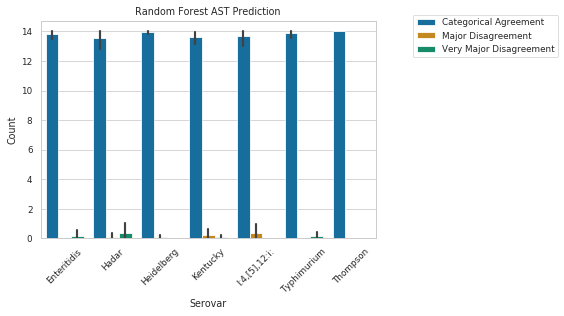

In [77]:
df = pd.melt(ml_fda, id_vars='Serovar', var_name='FDA Category', value_name='Count')
sns.barplot(data = df, x='Serovar', y='Count', hue='FDA Category')
_ = plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Random Forest AST Prediction')
#save_figure('amr/rf_ast_prediction_fda')

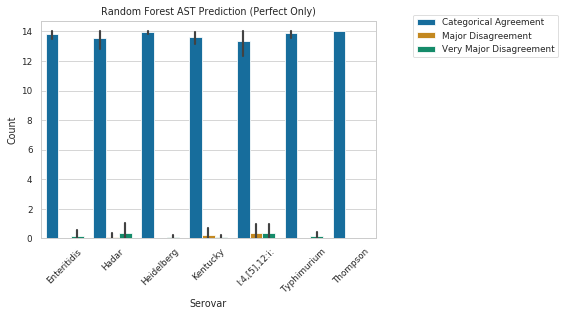

In [78]:
df = pd.melt(perf_ml_fda, id_vars='Serovar', var_name='FDA Category', value_name='Count')
sns.barplot(data = df, x='Serovar', y='Count', hue='FDA Category')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title('Random Forest AST Prediction (Perfect Only)')
_ = plt.xticks(rotation=45)
#save_figure('amr/rf_ast_prediction_perfect_fda')

In [82]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
X=rgi_encoded
for f in range(X.shape[1]):
    print("{}. feature: {} ({})".format(f + 1, rgi_encoded.columns[f], importances[indices[f]]))

# broken ccurrently to fix
# Plot the feature importances of the forest
#plt.figure(figsize=(10,5))
#plt.title("RandomForest AST Prediction Feature Importances")
##plt.bar(range(X.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")
#plt.ylabel('Mean Feature Importance')
#plt.xlabel('AMR Determinants')
#plt.xticks(range(X.shape[1]), rgi_encoded.columns[indices], rotation=90)
#plt.xlim([-1, X.shape[1]])
#plt.show()
#save_figure('amr/rf_feature_importances')

Feature ranking:
1. feature: Escherichia coli soxR with mutation conferring antibiotic resistance (0.4022006843601021)
2. feature: kdpE (0.1088459871392801)
3. feature: FosA7 (0.0934834472285427)
4. feature: tet(A) (0.08560768818309968)
5. feature: Escherichia coli mdfA (0.03906480367775633)
6. feature: MdtK (0.03265972789372833)
7. feature: golS (0.03058496859975983)
8. feature: PmrF (0.029576293105005133)
9. feature: sul1 (0.02611788594951438)
10. feature: Haemophilus influenzae PBP3 conferring resistance to beta-lactam antibiotics (0.022650098688564893)
11. feature: cpxA (0.020312498639041443)
12. feature: patA (0.019992165868365736)
13. feature: mdsB (0.018006281726917837)
14. feature: APH(3'')-Ib (0.014221975862049171)
15. feature: marA (0.0132127445185569)
16. feature: tetR (0.011757869001721266)
17. feature: AAC(6')-Iaa (0.011374930110154068)
18. feature: emrA (0.01081474967490206)
19. feature: H-NS (0.006903366374361762)
20. feature: aadA (0.002611833398576354)
21. feature: Esc

Worrying that emrD is so important despite not being associated with a drug class in CARD

In [84]:
importances = perf_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
X=rgi_encoded_perfect.drop('Serotype', axis=1)
for f in range(X.shape[1]):
    print("{}. feature: {} ({})".format(f + 1, rgi_encoded_perfect.columns[f], importances[indices[f]]))

# Plot the feature importances of the forest
#plt.figure()
#plt.title("RandomForest AST Prediction Feature Importances")
#plt.bar(range(X.shape[1]), importances[indices],
#       color="r", yerr=std[indices], align="center")

#plt.xticks(range(X.shape[1]), rgi_encoded_perfect.columns[indices], rotation=90)
#plt.xlim([-1, X.shape[1]])
#plt.ylabel('Mean Feature Importance')
#plt.xlabel('AMR Determinants')
#plt.show()
#save_figure('amr/rf_perfect_feature_importances')

Feature ranking:
1. feature: CMY-2 (0.4548299320474411)
2. feature: TEM-1 (0.13663384992420735)
3. feature: FosA7 (0.10333570133968384)
4. feature: tet(D) (0.08663417873977423)
5. feature: floR (0.0655159005293512)
6. feature: mdsB (0.03754772573521402)
7. feature: mdsC (0.031745439002548885)
8. feature: AAC(6')-Iaa (0.023251932338432025)
9. feature: sul2 (0.02256489262969164)
10. feature: golS (0.014571772820653832)
11. feature: sdiA (0.012450723974843408)
12. feature: sul1 (0.010917950918158678)
13. feature: AAC(6')-Iy (0.0)


Suspect this is probably overfitted to all hell.

#### Kovar 

Let's see how well we can perform without RGI labelling by just directly applying Kover/set covering machine approach to the contigs.

Might be interesting/redundant to use the methods used in https://www.biorxiv.org/content/biorxiv/early/2018/06/04/338194.full.pdf

Kover requires TSVs of the genomes `Genome_ID\tFasta_Path` and the metadata: separate files for each antibiotic `Genome_ID\t[1,0]` depending on resistance status

Let's try just cefotaxin first as its a the human alternative antibiotic of choice for Salmonella that we have in our dataset and has resistance (Ciprofloxacin is first choice but no resistance in our taxa)
`./kover/bin/kover dataset create from-contigs --genomic-data metadata/genome_metadata.tsv --phenotype-name cefotaxin --phenotype-metadata metadata/CEFOXI_metadata.tsv --output cefotaxin_dataset -x --n-cpu 1`

## CMY-2 Analysis

AAFC is really interested in CMY-2 so I grabbed all the fragments containing CMY-2 data. This does appear the most important determinant of the observed AST.

Basically, used cardprev and card canonical CMY-2 sequences to build nucleotide MSA.

Trained HMMer on that and searched the genomes using that via `search_for_cmy2.sh` script.

Then `get_cmy2_locus.py` was used to grab all CMY-2 loci within 5kbp of the cmy2 seq into `cmy2_loci.fasta` and the whole contigs  `cmy2_contig.fasta`.


Contigs were annotated using prokka:
`prokka --genus Salmonella --species enterica -gram neg --cpus=1 --evalue 1e-05 cmy2_contig.fasta --outdir cmy2_contig_annotation` and output to `CMY2_analysis/cmy2_contig_annotation`

In [888]:
headers = 'seqname source feature start end score strand frame attribute'.split()

with open('analyses/cmy2/cmy2_contigs_prokka.gff') as fh:
    with open('analyses/cmy2/prokka_gff_to_tsv', 'w') as out_fh:
        for line in fh:
            if not line.startswith('##'):
                out_fh.write(line)
            if line.startswith('>'):
                break

cmy2_df = pd.read_csv('analyses/cmy2/prokka_gff_to_tsv', sep='\t', names = headers)
cmy2_df['gene'] = cmy2_df['attribute'].str.split('product=').str.get(-1)

cmy2_df = cmy2_df[cmy2_df['gene'] != 'Beta-lactamase']

In [889]:
cmy2_df = cmy2_df[['seqname', 'gene']]

co_occurence = {}
for ix, row in cmy2_df.iterrows():
    if row['gene'] not in co_occurence:
        co_occurence.update({row['gene']: [row['seqname']]})
    else:
        co_occurence[row['gene']].append(row['seqname'])

co_occurence_count = []
for gene_name, contig_set in co_occurence.items():
    co_occurence_count.append([gene_name, len(set(contig_set))])


([], <a list of 0 Text xticklabel objects>)

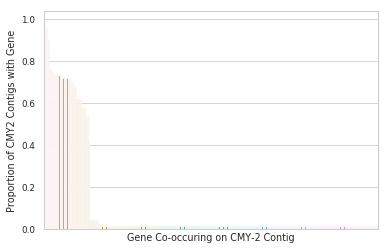

In [890]:
df = pd.DataFrame(co_occurence_count, columns=['Gene Co-occuring on CMY-2 Contig', 'Number of Co-occurences'])
df['Proportion of CMY2 Contigs with Gene'] = df['Number of Co-occurences'] / 71
df = df.sort_values('Proportion of CMY2 Contigs with Gene', ascending=False)

sns.barplot(x='Gene Co-occuring on CMY-2 Contig', y="Proportion of CMY2 Contigs with Gene", data=df)
plt.xticks([])


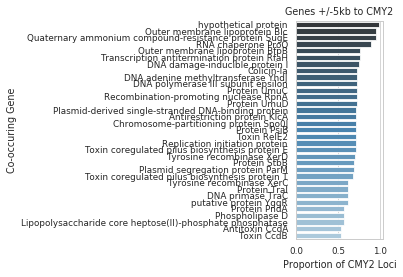

In [891]:
#fig, ax = plt.subplots(figsize=(3,5))


df = df[df['Proportion of CMY2 Contigs with Gene'] > 0.50]
sns.barplot(y='Gene Co-occuring on CMY-2 Contig', x="Proportion of CMY2 Contigs with Gene", data=df, palette="Blues_d")#, ax=ax)
plt.title('Genes +/-5kb to CMY2')
plt.ylabel('Co-occuring Gene')
plt.xlabel('Proportion of CMY2 Loci')
plt.subplots_adjust(left=0.7)
plt.savefig('analyses/cmy2/cmy2coccur.pdf')
plt.savefig('analyses/cmy2/cmy2coccur.svg')

## Virulence Factor Analysis

In [665]:
vfdf = pd.read_csv('analyses/vfdb/all_vfdb.tsv', sep='\t')
vfdf['ID'] = vfdf['#FILE'].str.replace('.tab', '')
vfdf = vfdf.set_index('ID')
vfdf = vfdf.replace('.', '0.0')
vfdf = vfdf.drop(['#FILE', 'NUM_FOUND'], axis=1)

# replace multihits with tophit
vfdf.loc[vfdf.select_dtypes(object).index, vfdf.select_dtypes(object).columns] = vfdf.select_dtypes(object).applymap(lambda x: max([float(y) for y in x.split(';')]))

In [666]:
# ubiquitous factors

print(vfdf.columns[vfdf.min() > 95].shape)
vf_type = []
for vf in vfdf.columns[vfdf.min() > 95]:
    print(vf, end=', ')
    vf_name = vf[:3]
    vf_type.append(vf[:3])
from collections import Counter
print(Counter(vf_type))

# those with a more varied distribution
vfdf_different = vfdf.drop(vfdf.columns[vfdf.min() > 95], axis=1)

(107,)
avrA, cheY, csgA, csgB, csgC, csgD, csgE, csgF, csgG, entA, entB, entC, entE, entS, fepA, fepC, fepD, fimC, fimD, fimF, fimH, fimI, flgG, fliA, fliG, fliM, fliP, invA, invB, invC, invE, invF, invG, invI, invJ, iroB, iroC, iroN, lpfB, lpfC, lpfE, mgtB, mgtC, mig-14, misL, ompA, orgA, orgB, orgC, pipB, pipB2, prgH, prgI, prgJ, prgK, sicA, sicP, sifA, sifB, sipA/sspA, sipB/sspB, sipC/sspC, sipD, slrP, sopA, sopB/sigD, sopD, sopD2, spaO, spaP, spaQ, spaR, spaS, spiC/ssaB, sptP, ssaC, ssaD, ssaE, ssaG, ssaH, ssaI, ssaJ, ssaK, ssaL, ssaM, ssaN, ssaO, ssaP, ssaQ, ssaR, ssaS, ssaT, ssaU, sscA, sscB, sseA, sseB, sseC, sseD, sseE, sseF, sseG, sseJ, sseL, steA, steB, steC, Counter({'ssa': 18, 'sse': 9, 'inv': 8, 'csg': 7, 'ent': 5, 'fim': 5, 'spa': 5, 'fli': 4, 'prg': 4, 'sip': 4, 'sop': 4, 'fep': 3, 'iro': 3, 'lpf': 3, 'org': 3, 'ste': 3, 'mgt': 2, 'pip': 2, 'sic': 2, 'sif': 2, 'ssc': 2, 'avr': 1, 'che': 1, 'flg': 1, 'mig': 1, 'mis': 1, 'omp': 1, 'slr': 1, 'spi': 1, 'spt': 1})


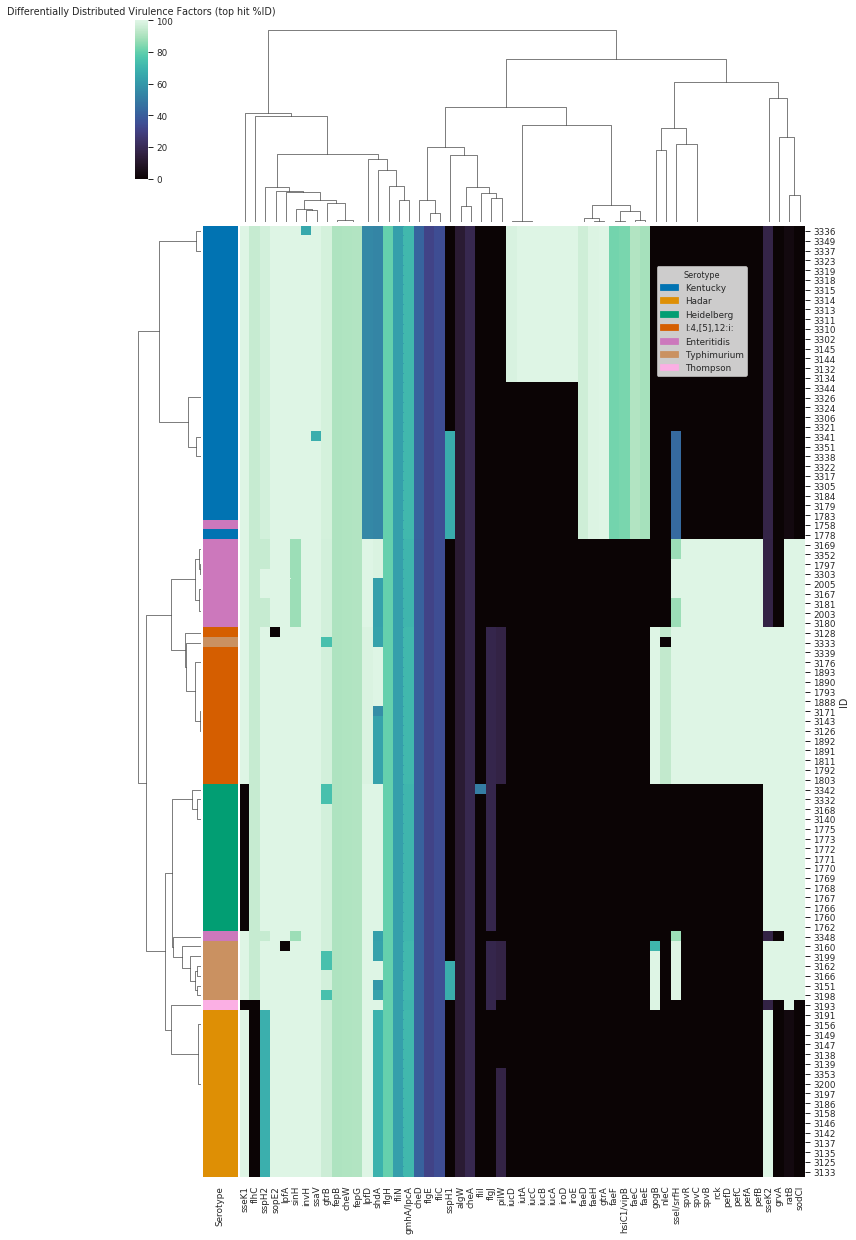

In [667]:
sero = ast_df['Serotype'].loc[sir_labels.index]
colors = sero.map(sero_lut)

g = sns.clustermap(vfdf_different, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')

plt.title("Differentially Distributed Virulence Factors (top hit %ID)")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.73,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)

In [668]:
# let's get data from VFDB
sal_vf = pd.read_excel('analyses/vfdb/Salmonella_VFs_comparsion.xls', skiprows=1)
sal_vf = sal_vf[['Virulence factors', 'Related genes']]
sal_vf['Type'] = sal_vf.loc[sal_vf['Related genes'].isna(), 'Virulence factors']
sal_vf['Type'] = sal_vf.loc[sal_vf['Related genes'].isna(), 'Virulence factors']
sal_vf['Virulence factors'] = sal_vf['Virulence factors'].fillna(method='ffill')
sal_vf['Type'] = sal_vf['Type'].fillna(method='ffill')
sal_vf = sal_vf.drop(sal_vf.index[sal_vf['Related genes'].isna()])

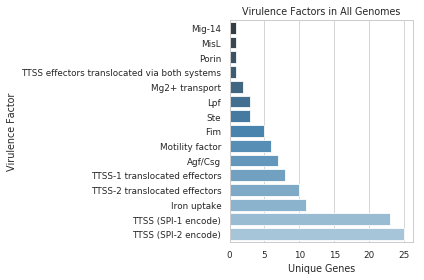

In [892]:
genes_per_factor = sal_vf.groupby('Virulence factors').size()

gene_to_factor = pd.Series(sal_vf['Virulence factors'].values, index=sal_vf['Related genes']).to_dict()

factors = []
for vf in vfdf.columns[vfdf.min() > 95]:
    try:
        factors.append(gene_to_factor[vf])
    except:
        # these have a backslash annoyingly so aren't counted
        if vf.startswith('sip'):
            vf = vf.split('/')[0]
            factors.append(gene_to_factor[vf])
        elif vf.startswith('che') or vf.startswith('fli') or vf.startswith('flg'):
            factors.append('Motility factor')
        elif vf.startswith('ent') or vf.startswith('fep') or vf.startswith('iro'):
            factors.append('Iron uptake')
        elif vf.startswith('omp'):
            factors.append('Porin')
        else:
            print(vf)
            factors.append('Non Salmonella')

            
df = pd.Series(dict(Counter(factors))).reset_index().sort_values(by=0)
sns.barplot(data = df, y='index', x=0, palette="Blues_d")
#plt.xticks(rotation=90)
plt.title('Virulence Factors in All Genomes')
plt.xlabel('Unique Genes')
plt.ylabel('Virulence Factor')
plt.tight_layout()
plt.savefig('analyses/vfdb/ubiqvf.pdf')
plt.savefig('analyses/vfdb/ubiqvf.svg')

In [670]:
vfdf_different = vfdf.drop(vfdf.columns[vfdf.min() > 95], axis=1)
vfdf_different[vfdf_different < 95] = 0
vfdf_different[vfdf_different > 95] = 1
vfdf_different = vfdf_different.loc[:, vfdf_different.columns[vfdf_different.max() > 0]]

In [671]:

diff_gene_to_factor = {}
for col in vfdf_different:
    try:
        diff_gene_to_factor.update({col: gene_to_factor[col]})
    except:
        if col.startswith('iuc') or col.startswith('iro') or col.startswith('iut'):
            diff_gene_to_factor.update({col: 'Iron uptake'})
        elif col.startswith('grvA'):
            diff_gene_to_factor.update({col: 'Antivirulence'})
        elif col.startswith('fae'):
            diff_gene_to_factor.update({col: 'K88 fimbriaea'})
        elif col.startswith('flhC'):
            diff_gene_to_factor.update({col: 'Flagella'})
        elif col.startswith('gtr'):
            diff_gene_to_factor.update({col: 'Endotoxin'})
        else:
            print(col)
#vfdf_diff_group[gene_to_factor[col]] += vfdf_different[col]
vfdf_diff_group = pd.DataFrame(index=vfdf_different.index, columns=set(diff_gene_to_factor.values())).fillna(0)


for col in vfdf_different:
    vfdf_diff_group[diff_gene_to_factor[col]] += vfdf_different[col]

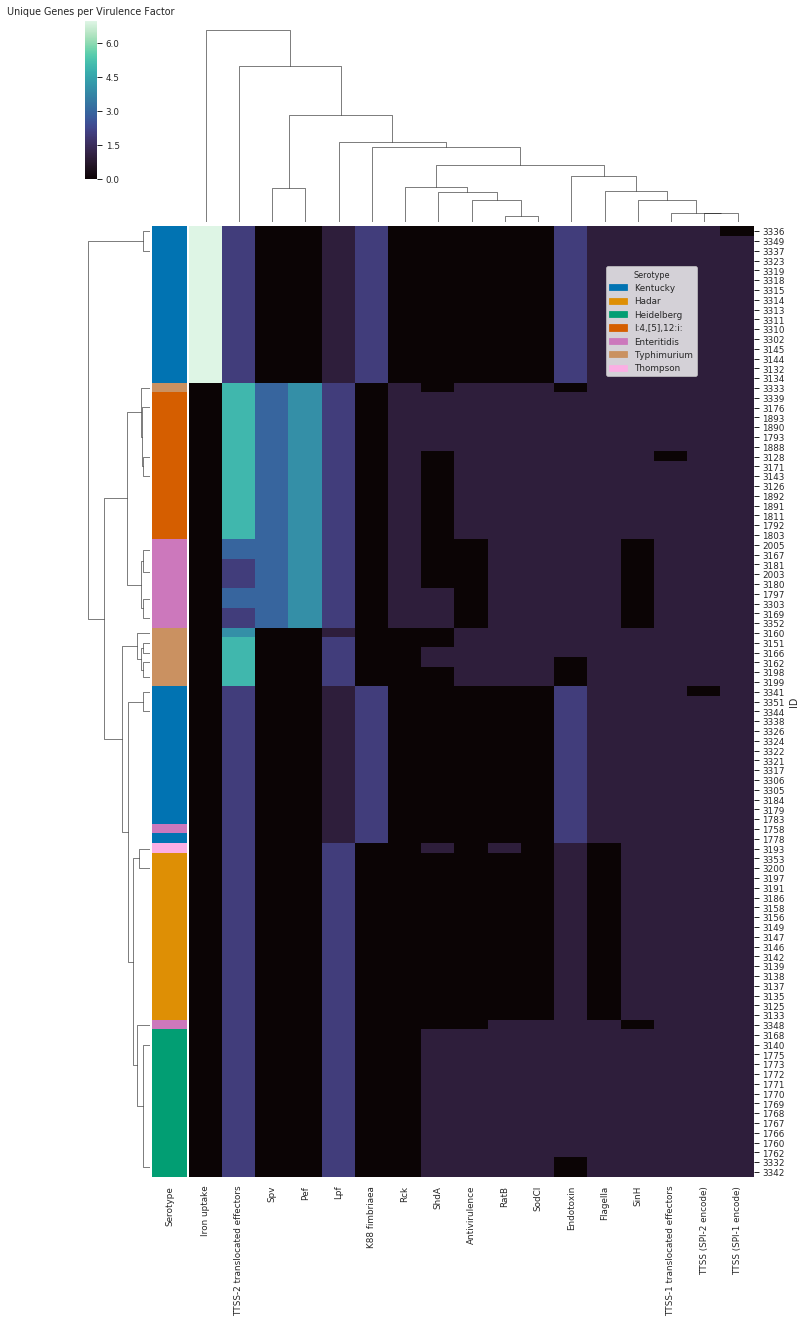

In [672]:
sero = ast_df['Serotype'].loc[sir_labels.index]
colors = sero.map(sero_lut)

g = sns.clustermap(vfdf_diff_group, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')

plt.title("Unique Genes per Virulence Factor")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.73,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.savefig('analyses/vfdb/vfdbdiffheatmap.pdf')
plt.savefig('analyses/vfdb/vfdbdiffheatmap.svg')

In [439]:
vfdf_diff_group['Serotype'] = ast_df['Serotype'].loc[vfdf_diff_group.index]

In [468]:
df = pd.melt(vfdf_diff_group, id_vars='Serotype', var_name='Virulence factor', value_name='Unique genes')
sns.factorplot(kind='strip', data = df, x = 'Virulence factor', y = 'Unique genes', col='Serotype', col_wrap=3)
plt.xticks(rotation=90)

KeyError: 'Serotype'

## Plasmid Sequences

In [673]:
pdf = pd.read_csv('analyses/plasmids/all_plasmids.tsv', sep='\t')
pdf['ID'] = pdf['#FILE'].str.replace('.tab', '')
pdf = pdf.set_index('ID')
pdf = pdf.replace('.', '0.0')
pdf = pdf.drop(['#FILE', 'NUM_FOUND', 'Unnamed: 2'], axis=1)
pdf.loc[pdf.select_dtypes(object).index, pdf.select_dtypes(object).columns] = pdf.select_dtypes(object).applymap(lambda x: max([float(y) for y in x.split(';')]))

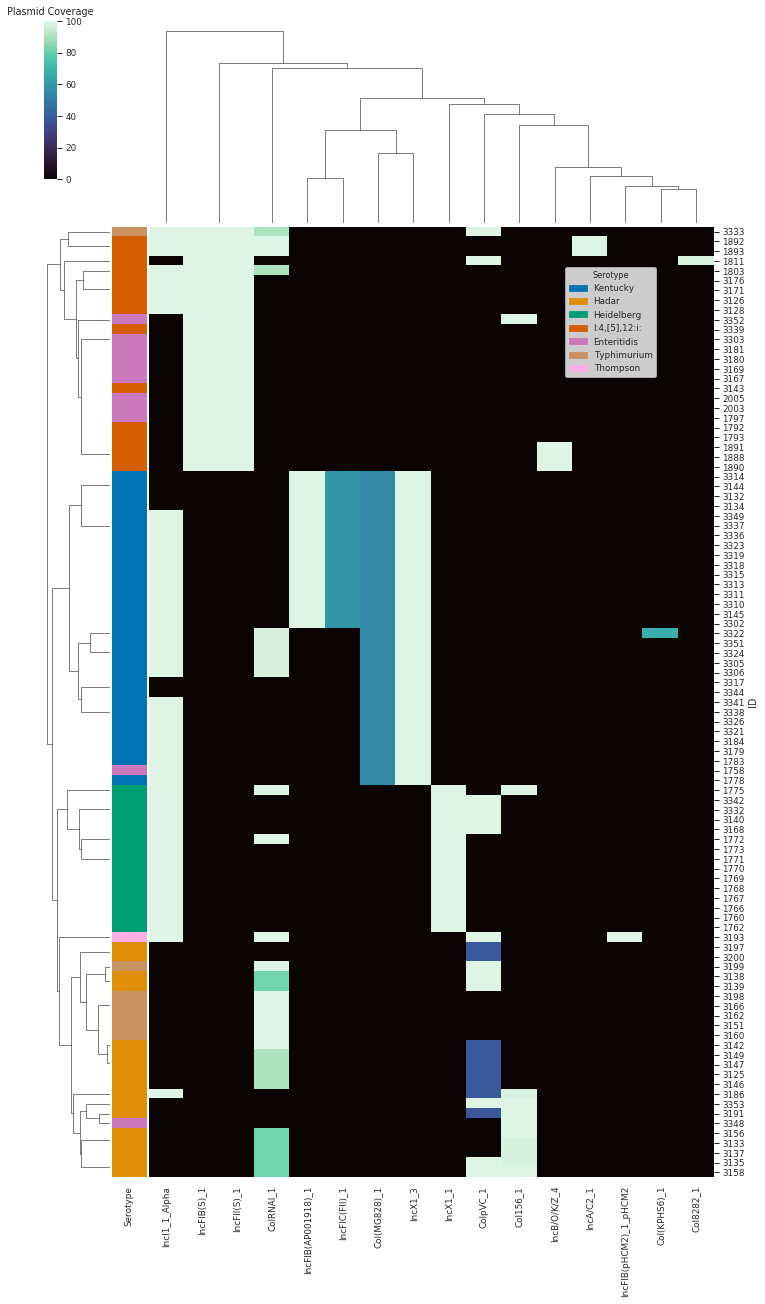

In [674]:
sero = ast_df['Serotype'].loc[sir_labels.index]
colors = sero.map(sero_lut)

g = sns.clustermap(pdf, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')

plt.title("Plasmid Coverage")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.73,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.savefig('analyses/plasmids/plasmidheatmap.pdf')

In [943]:
pdf['Sero'] = ast_df['Serotype'].loc[pdf.index]

In [965]:
df = pdf[pdf > 50].drop('Sero', axis=1).apply(pd.DataFrame.describe, axis=1)
print(df[df['count'] == 0])

pdf.loc[['3197', '3200']]

      count  mean  std  min  25%  50%  75%  max
ID                                             
3197    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN
3200    0.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN


,Col(KPHS6)_1,Col(MG828)_1,Col156_1,Col8282_1,ColRNAI_1,ColpVC_1,IncA/C2_1,IncB/O/K/Z_4,IncFIB(AP001918)_1,IncFIB(S)_1,IncFIB(pHCM2)_1_pHCM2,IncFIC(FII)_1,IncFII(S)_1,IncI1_1_Alpha,IncX1_1,IncX1_3,Sero
ID,,,,,,,,,,,,,,,,,
3197,0.0,0.0,0.0,0.0,0.0,38.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hadar
3200,0.0,0.0,0.0,0.0,0.0,38.34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Hadar



## Hypermutator Sequences

In [675]:
tables = []
for blast_table in glob('analyses/hypermutator/*.out6'):
    df = pd.read_csv(blast_table, sep='\t', names='qseqid sseqid pident length mismatch gapopen qstart qend sstart send evalue bitscore'.split())
    df['ID'] = blast_table.split('/')[-1].replace('.out6', '')
    tables.append(df)
    
hyperdf = pd.concat(tables)
hyperdf_pident = pd.DataFrame(index=hyperdf['ID'].unique(), columns=hyperdf['sseqid'].unique())

#hyperdf = hyperdf[hyperdf['pident'] >= 85]
#hyperdf.groupby('ID')['sseqid'].nunique()

for ix, row in hyperdf.iterrows():
    hyperdf_pident.loc[row['ID'], row['sseqid']] = row['pident']

hyperdf_pident = hyperdf_pident.fillna(0)

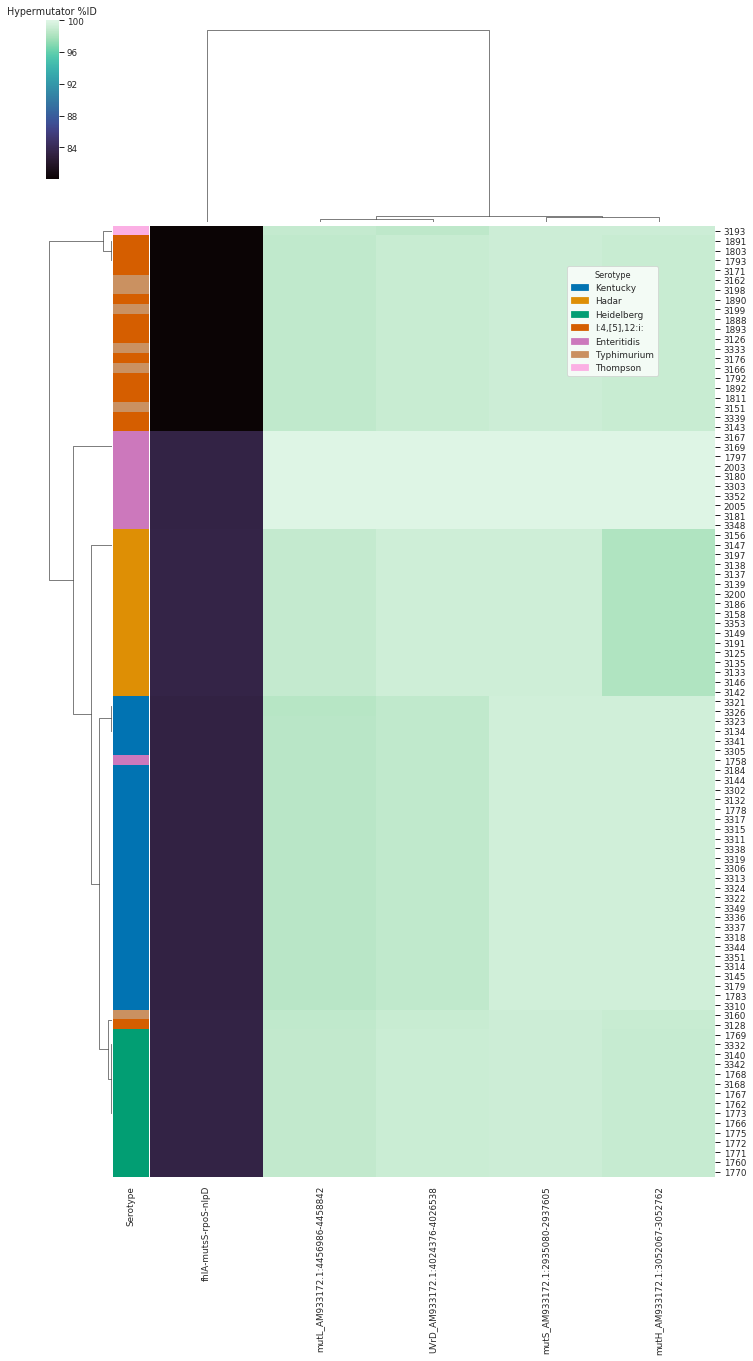

In [676]:
sero = ast_df['Serotype'].loc[sir_labels.index]
colors = sero.map(sero_lut)

g = sns.clustermap(hyperdf_pident, row_colors=colors, xticklabels=True, 
                   yticklabels=True, figsize=(12,22), cmap='mako')

plt.title("Hypermutator %ID")
l2 = g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(0.73,0.9),handles=legend_TN, frameon=True)
l2.set_title(title='Serotype',prop={'size':8})
_ = plt.subplots_adjust(bottom=0.15)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90)
plt.savefig('analyses/hypermutator/hypermutheatmap.pdf')


In [936]:
hyperdf_pident

,mutS_AM933172.1:2935080-2937605,fhlA-mutsS-rpoS-nlpD,mutH_AM933172.1:3052067-3052762,mutL_AM933172.1:4456986-4458842,UVrD_AM933172.1:4024376-4026538
1760,99.248,83.340,98.994,98.869,99.168
1783,99.406,83.301,99.425,98.546,98.798
3181,100.000,83.340,100.000,100.000,100.000
3146,99.367,83.419,98.276,98.923,99.307
3339,99.287,80.096,99.138,98.761,99.075
3310,99.406,83.301,99.425,98.546,98.798
3179,99.406,83.301,99.425,98.546,98.798
3142,99.367,83.419,98.276,98.923,99.307
1770,99.248,83.340,98.994,98.869,99.168
3348,100.000,83.340,100.000,100.000,100.000


In [622]:
df = pd.melt(hyperdf_pident, id_vars = 'Serotype', var_name='Hypermutator', value_name='% ID')
df = df.fillna(0)
low_df = df[df['Hypermutator'] == 'fhlA-mutsS-rpoS-nlpD']
df = df[df['Hypermutator'] != 'fhlA-mutsS-rpoS-nlpD']
sns.factorplot(data = df, x='Serotype', y='% ID', hue='Serotype', col_wrap=2, col='Hypermutator', kind='box', hue_order=sero_order)

KeyError: 'Serotype'

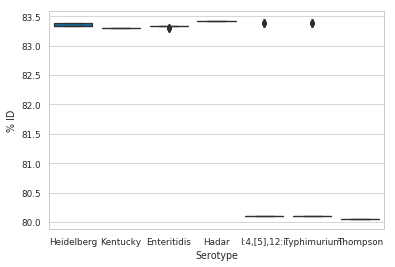

In [582]:
sns.boxplot(data = low_df, x='Serotype', y='% ID')